# Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL2

Mounted at /gdrive
/gdrive/My Drive/ANNDL2


In [2]:
!ls

1D_CNN_Autoencoder			       residual_model_classifier
1DCNN_classifier			       residual_model_masking_classifier
1DCNN_deeper_classifier			       submission_3_19_12_Ilenia.zip
AirQuality.csv				       submission_3_20_12.zip
big_model_classifier			       test_model.h5
BiLSTM_classifier			       training_data.npy
categories.npy				       training_dataset.zip
CONV_LSTM_long_data			       transformer_classifier
CONV_LSTM_long_data-20231219T204717Z-001.zip   transformer_classifier_2
CONV_LSTM_short_data			       transformer_deeper_forecasting
CONV_LSTM_short_data-20231219T204718Z-001.zip  transformer_deeper_forecasting_tensorflow
LSTM					       transformer_forecasting
LSTM_1					       transformer_forecasting_tensorflow
LSTM_2_Attention			       transformer_forecasting_try
LSTM_2_Attention_stride_50		       transformer_forecasting_with_classes
LSTM_3_CNN				       transformer_forecasting_with_classes_2
LSTM_classifier				       transformer_forecasting_with_classes_2_tensorflow
LSTM_CNN			

# Data Import and Preprocessing

### Import libraries

In [3]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [4]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [5]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Load and process data

In [6]:
dataset = np.load('training_data.npy')
valid_periods = np.load('valid_periods.npy')
categories = np.load('categories.npy')

In [7]:
np.unique(categories, return_index=True, return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'),
 array([20991, 36736, 26719,     0, 10016, 47723]),
 array([ 5728, 10987, 10017, 10016, 10975,   277]))

## visualization

In [8]:
np.min([2776 - valid_periods[i][0] for i in range(2776)])

43

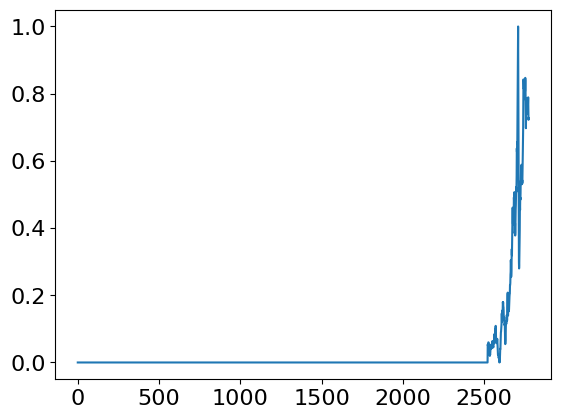

In [9]:
plt.plot(dataset[250])

In [10]:
num_samples = dataset.shape[0]

In [11]:
list_of_signals = list()

for i in range(0,num_samples):
  list_of_signals.append(dataset[i,valid_periods[i,0]: valid_periods[i,1]])

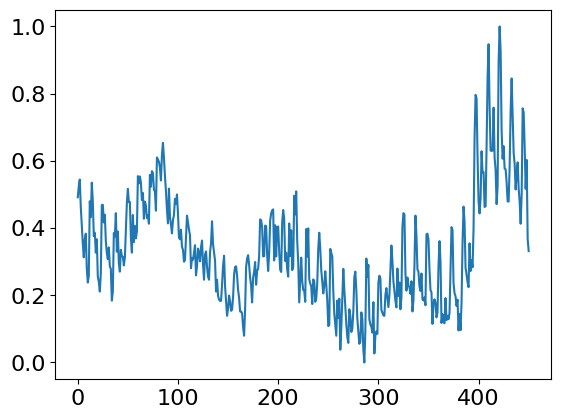

In [12]:
plt.plot(list_of_signals[0])

In [13]:
figs, axs = plt.subplots(10, 1, sharex=True, figsize=(17,17))
for i in range(20991, 20991+10):
    axs[i-20991].plot(list_of_signals[i])
    axs[i-20991].set_title(categories[i])
plt.show()

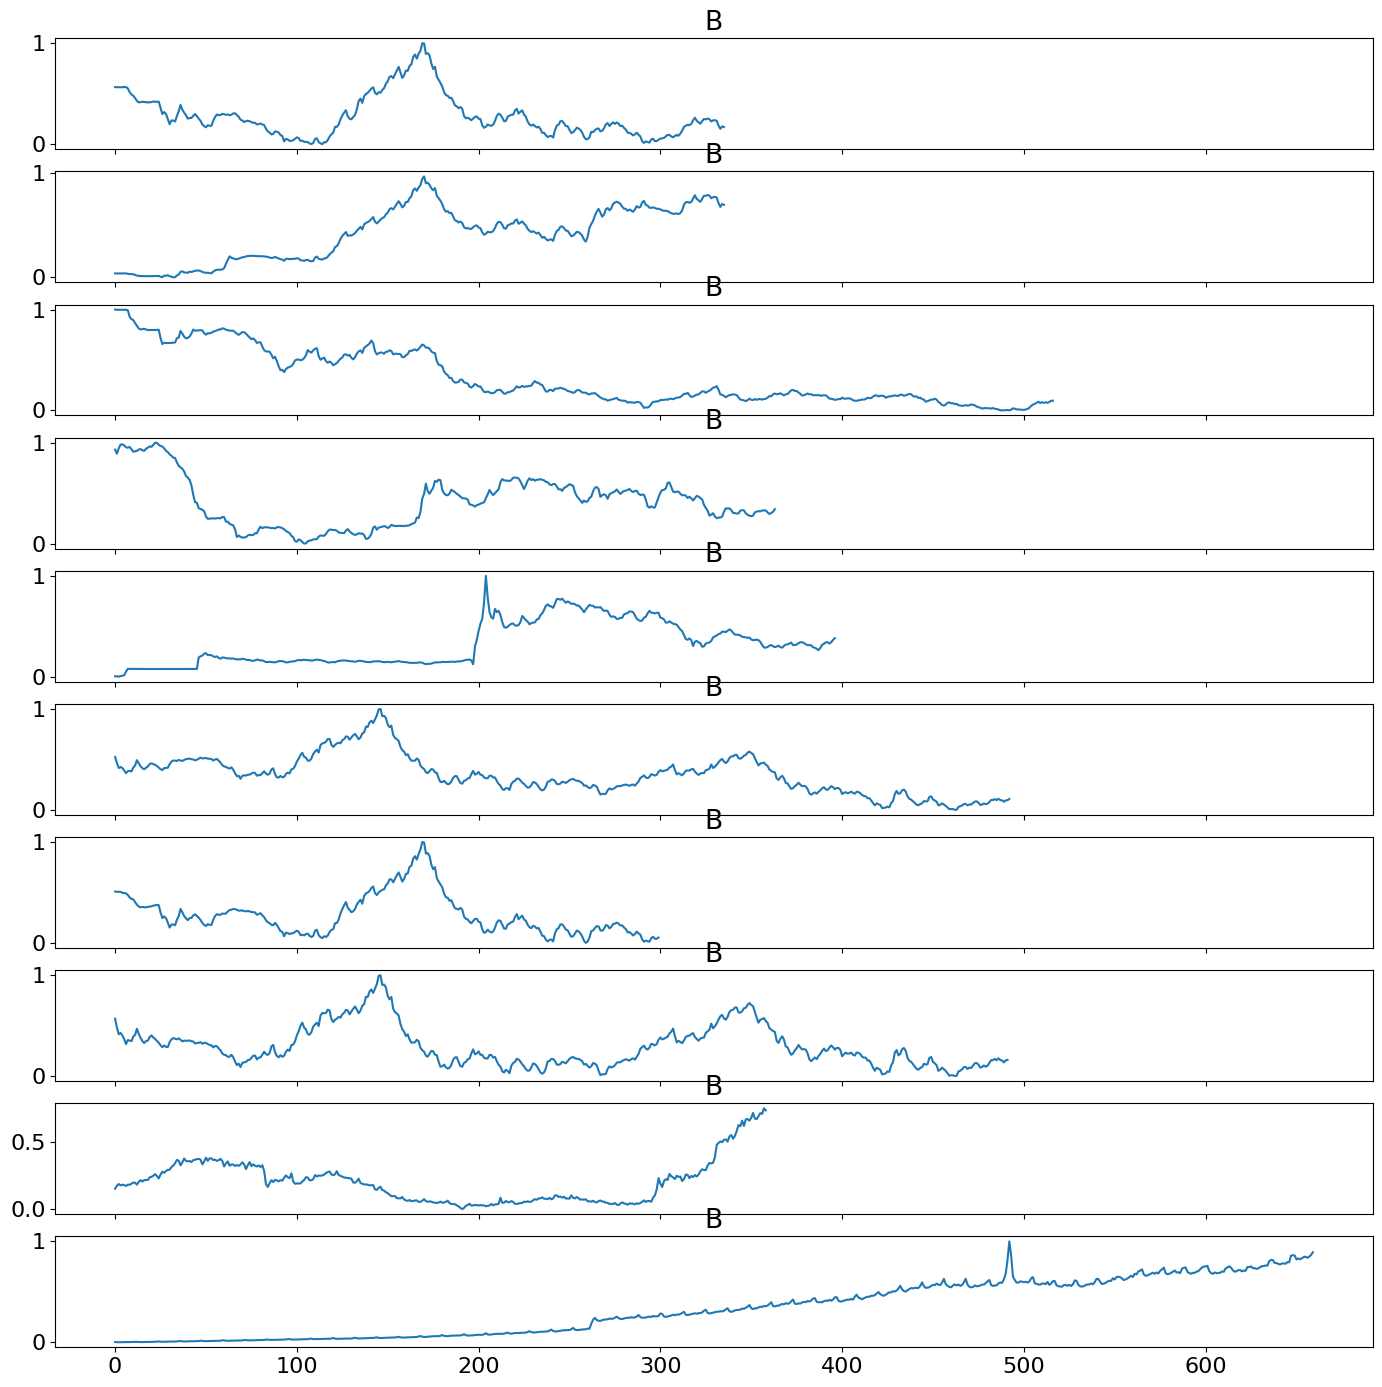

In [14]:
figs, axs = plt.subplots(10, 1, sharex=True, figsize=(17,17))
index = 36736
for i in range(index, index+10):
    axs[i-index].plot(list_of_signals[i])
    axs[i-index].set_title(categories[i])
plt.show()

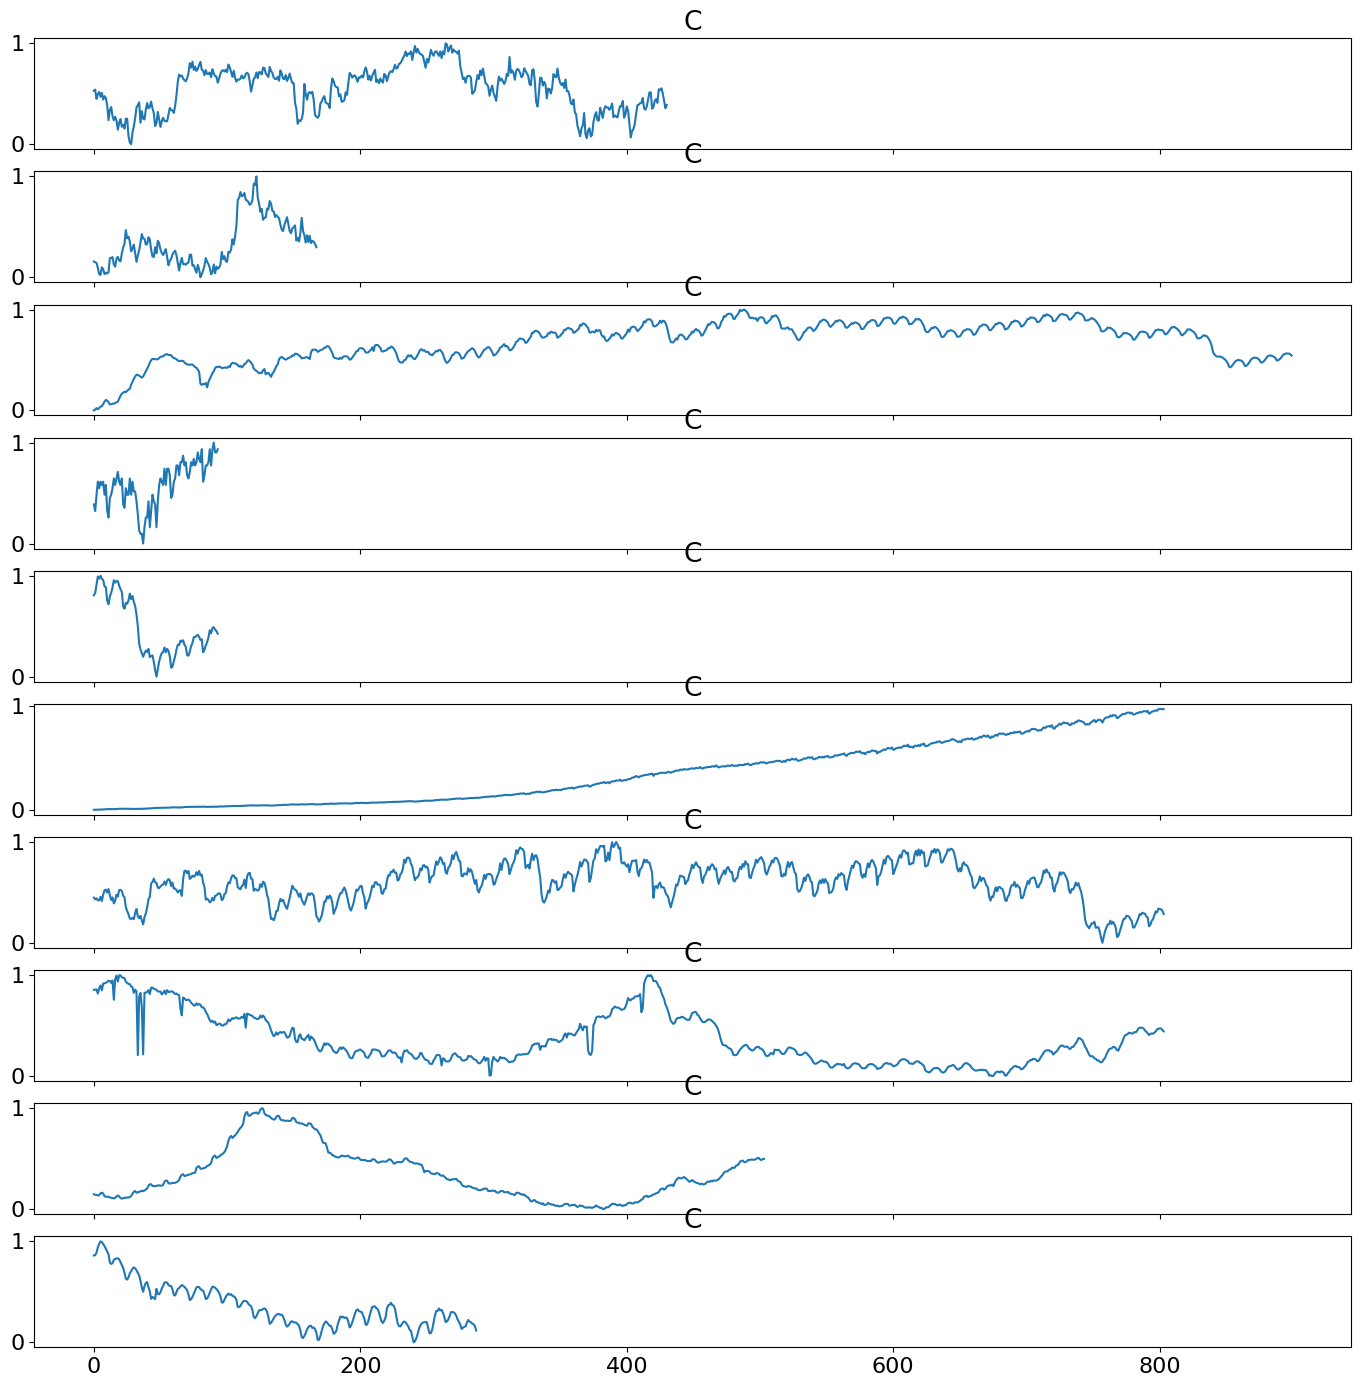

In [15]:
figs, axs = plt.subplots(10, 1, sharex=True, figsize=(17,17))
index = 26719
for i in range(index, index+10):
    axs[i-index].plot(list_of_signals[i])
    axs[i-index].set_title(categories[i])
plt.show()

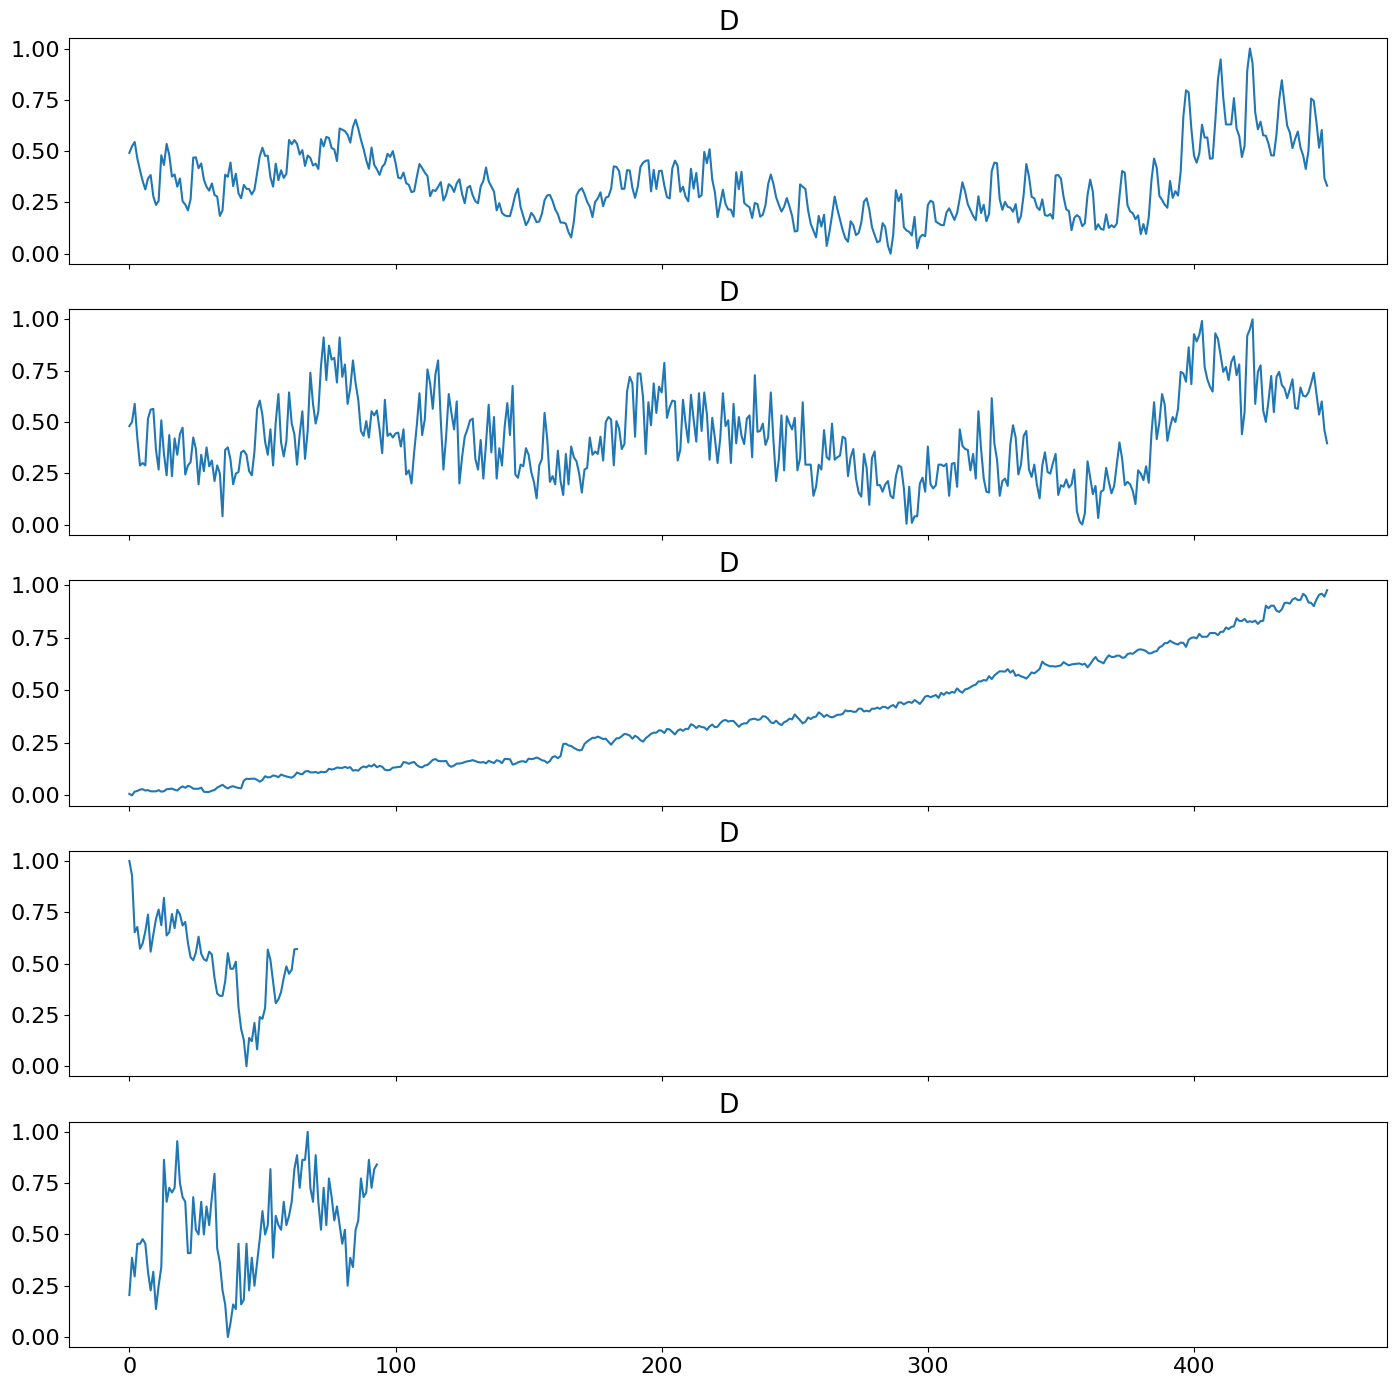

In [16]:
figs, axs = plt.subplots(5, 1, sharex=True, figsize=(17,17))
for i in range(5):
    axs[i].plot(list_of_signals[i])
    axs[i].set_title(categories[i])
plt.show()

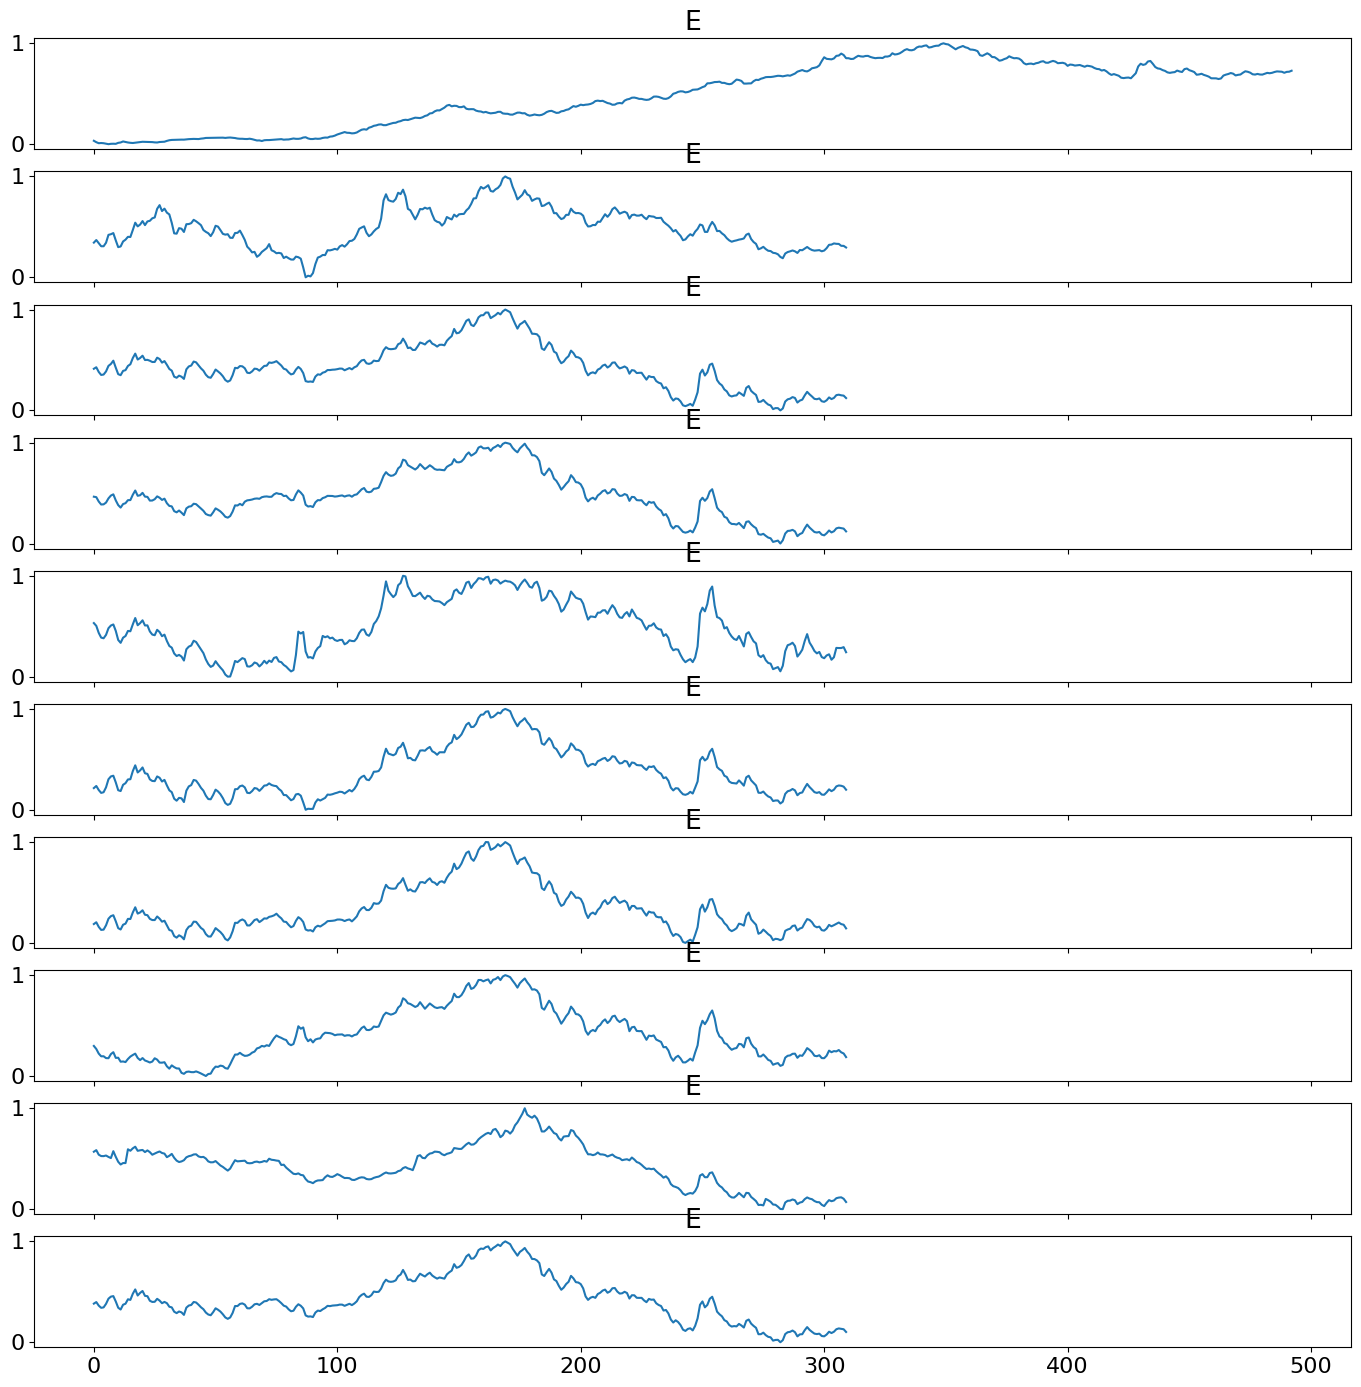

In [17]:
figs, axs = plt.subplots(10, 1, sharex=True, figsize=(17,17))
index = 10016
for i in range(index, index+10):
    axs[i-index].plot(list_of_signals[i])
    axs[i-index].set_title(categories[i])
plt.show()

In [18]:
figs, axs = plt.subplots(10, 1, sharex=True, figsize=(17,17))
index = 47723
for i in range(index, index+10):
    axs[i-index].plot(list_of_signals[i])
    axs[i-index].set_title(categories[i])
plt.show()

# Classification

### Data Preprocessing

In [19]:
unique_labels, indexes, counts = np.unique(categories, return_index=True, return_counts=True)

In [20]:
class_labels_numerical = [i for i in range(len(unique_labels))]
class_labels_numerical

[0, 1, 2, 3, 4, 5]

In [21]:
total_samples = num_samples
class_weights = {cls: total_samples / (len(unique_labels) * count) for cls, count in zip(class_labels_numerical, counts)}

In [22]:
class_weights

{0: 1.3966480446927374,
 1: 0.7281332483844544,
 2: 0.7986423080762703,
 3: 0.7987220447284346,
 4: 0.7289293849658315,
 5: 28.880866425992778}

In [46]:
# robust scaling of the signals
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler instance
scaler = RobustScaler()

scaled_signals = list()

for i in range(len(list_of_signals)):
    original_data = list_of_signals[i].reshape(-1, 1)
    # Fit and transform the data
    scaled_data = scaler.fit_transform(original_data)
    scaled_signals.append(np.squeeze(scaled_data, axis=1))
    # Extract the parameters
    median = scaler.center_[0]
    iqr = scaler.scale_[0]
    # Invert the transformation
    inverted_data = (scaled_data * iqr) + median

KeyboardInterrupt: ignored

In [24]:
print(median)
print(iqr)

0.7057926829268293
0.2179878048780488


In [25]:
plt.plot(list_of_signals[250])

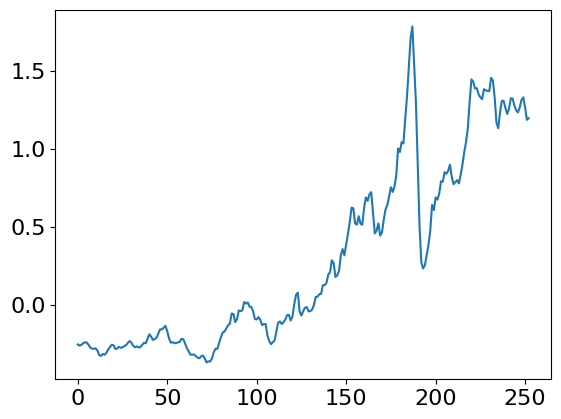

In [26]:
plt.plot(scaled_signals[250])

In [27]:
test_prop = 0.25
val_prop = 0.25
X_train_raw = list()
y_train_raw = list()
X_test_raw = list()
y_test_raw = list()
X_val_raw = list()
y_val_raw = list()

random_indexes = np.arange(len(scaled_signals))
np.random.shuffle(random_indexes)
shuffled_scaled_signals = [scaled_signals[i] for i in random_indexes]
shuffled_categories = categories[random_indexes]
# see if uniformly sampling changes something

for i in range(len(unique_labels)):
  idx_start = indexes[i]
  idx_train = indexes[i] + int(counts[i]*(1-test_prop-val_prop))
  idx_val = indexes[i] + int(counts[i]*(1-test_prop))
  idx_end = indexes[i] + counts[i]
  X_train_raw.extend(shuffled_scaled_signals[idx_start:idx_train])
  y_train_raw.extend(shuffled_categories[idx_start:idx_train])
  X_val_raw.extend(shuffled_scaled_signals[idx_train:idx_val])
  y_val_raw.extend(shuffled_categories[idx_train:idx_val])
  X_test_raw.extend(shuffled_scaled_signals[idx_val:idx_end])
  y_test_raw.extend(shuffled_categories[idx_val:idx_end])

X_train_raw = np.array(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.array(X_test_raw)
y_test_raw = np.array(y_test_raw)
X_val_raw = np.array(X_val_raw)
y_val_raw = np.array(y_val_raw)

In [28]:
# THIS IS NOT AN OFFICIAL CODE
# I JUST WANT TO SEE WHAT THE PROBLEM IS WITH THE SEQUENCES IN CLASS 'E'
'''
test_prop = 0.25
val_prop = 0.25
X_train_raw = list()
y_train_raw = list()
X_test_raw = list()
y_test_raw = list()
X_val_raw = list()
y_val_raw = list()

shuffled_scaled_signals = scaled_signals
shuffled_categories = categories

for i in range(len(unique_labels)):
  idx_start = indexes[i]
  idx_train = indexes[i] + int(counts[i]*(1-test_prop-val_prop))
  idx_val = indexes[i] + int(counts[i]*(1-test_prop))
  idx_end = indexes[i] + counts[i]
  X_train_raw.extend(shuffled_scaled_signals[idx_start:idx_train])
  y_train_raw.extend(shuffled_categories[idx_start:idx_train])
  X_val_raw.extend(shuffled_scaled_signals[idx_train:idx_val])
  y_val_raw.extend(shuffled_categories[idx_train:idx_val])
  X_test_raw.extend(shuffled_scaled_signals[idx_val:idx_end])
  y_test_raw.extend(shuffled_categories[idx_val:idx_end])

X_train_raw = np.array(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.array(X_test_raw)
y_test_raw = np.array(y_test_raw)
X_val_raw = np.array(X_val_raw)
y_val_raw = np.array(y_val_raw)
'''

'\ntest_prop = 0.25\nval_prop = 0.25\nX_train_raw = list()\ny_train_raw = list()\nX_test_raw = list()\ny_test_raw = list()\nX_val_raw = list()\ny_val_raw = list()\n\nshuffled_scaled_signals = scaled_signals\nshuffled_categories = categories\n\nfor i in range(len(unique_labels)):\n  idx_start = indexes[i]\n  idx_train = indexes[i] + int(counts[i]*(1-test_prop-val_prop))\n  idx_val = indexes[i] + int(counts[i]*(1-test_prop))\n  idx_end = indexes[i] + counts[i]\n  X_train_raw.extend(shuffled_scaled_signals[idx_start:idx_train])\n  y_train_raw.extend(shuffled_categories[idx_start:idx_train])\n  X_val_raw.extend(shuffled_scaled_signals[idx_train:idx_val])\n  y_val_raw.extend(shuffled_categories[idx_train:idx_val])\n  X_test_raw.extend(shuffled_scaled_signals[idx_val:idx_end])\n  y_test_raw.extend(shuffled_categories[idx_val:idx_end])\n\nX_train_raw = np.array(X_train_raw)\ny_train_raw = np.array(y_train_raw)\nX_test_raw = np.array(X_test_raw)\ny_test_raw = np.array(y_test_raw)\nX_val_raw = 

In [29]:
X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape, X_val_raw.shape, y_val_raw.shape

((23998,), (23998,), (12002,), (12002,), (12000,), (12000,))

In [30]:
np.unique(y_train_raw, return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'),
 array([2798, 5484, 5026, 4996, 5551,  143]))

In [31]:
np.unique(y_val_raw, return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'),
 array([1500, 2707, 2523, 2508, 2695,   67]))

In [32]:
np.unique(y_test_raw, return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'),
 array([1430, 2796, 2468, 2512, 2729,   67]))

In [33]:
window = 200
stride = 50

def build_sequences_classification(X, categories, window, stride):
  new_X = []
  new_dataset = []
  new_labels_dataset = []
  for seq in X:
    padding_check = len(seq)%window
    n_of_windows = len(seq)//window
    if padding_check != 0:
      padding_len = window*(n_of_windows+1) - len(seq)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, seq))
    new_X.append(temp_unit)


  for i in range(len(new_X)):
      seq = new_X[i]
      if seq.shape[0] == 200:
        end = 1
      else:
        end = seq.shape[0]-window

      for idx in range(0, end, stride):
          elem = np.array(new_X[i][idx:idx+window])
          lab = categories[i]
          #lab = np.array(new_X[i][idx+window:idx+window+telescope]) # prediction labels
          new_dataset.append(elem)
          new_labels_dataset.append(lab)
          if elem.shape != (window,):
            print("error at index:")
            print(idx)

  new_dataset = np.array(new_dataset)
  new_labels_dataset = np.array(new_labels_dataset)

  return new_X, new_dataset, new_labels_dataset

In [34]:
'''
window = 200
stride = 50
X = X_test_raw
categories = y_test_raw

new_X = []
new_dataset = []
new_labels_dataset = []
for seq in X:
  padding_check = len(seq)%window
  n_of_windows = len(seq)//window
  if padding_check != 0:
    padding_len = window*(n_of_windows+1) - len(seq)
    padding = np.zeros(padding_len, dtype='float32')
    temp_unit = np.concatenate((padding, seq))
  new_X.append(temp_unit)

#print(len(new_X))
for i in range(len(new_X)):
  seq = new_X[i]
  #print('outer i')
  #print(i)
  #print(seq.shape[0]-window)
  #print(seq.shape)
  if seq.shape[0] == 200:
    end = 1
  else:
    end = seq.shape[0]-window
  for idx in range(0, end, stride):
    elem = np.array(new_X[i][idx:idx+window])
    lab = categories[i]
    #lab = np.array(new_X[i][idx+window:idx+window+telescope]) # prediction labels
    #print('inner i')
    #print(i)
    new_dataset.append(elem)
    new_labels_dataset.append(lab)
    if elem.shape != (window,):
      print("error at index:")
      print(idx)

new_dataset = np.array(new_dataset)
new_labels_dataset = np.array(new_labels_dataset)
'''

'\nwindow = 200\nstride = 50\nX = X_test_raw\ncategories = y_test_raw\n\nnew_X = []\nnew_dataset = []\nnew_labels_dataset = []\nfor seq in X:\n  padding_check = len(seq)%window\n  n_of_windows = len(seq)//window\n  if padding_check != 0:\n    padding_len = window*(n_of_windows+1) - len(seq)\n    padding = np.zeros(padding_len, dtype=\'float32\')\n    temp_unit = np.concatenate((padding, seq))\n  new_X.append(temp_unit)\n\n#print(len(new_X))\nfor i in range(len(new_X)):\n  seq = new_X[i]\n  #print(\'outer i\')\n  #print(i)\n  #print(seq.shape[0]-window)\n  #print(seq.shape)\n  if seq.shape[0] == 200:\n    end = 1\n  else:\n    end = seq.shape[0]-window\n  for idx in range(0, end, stride):\n    elem = np.array(new_X[i][idx:idx+window])\n    lab = categories[i]\n    #lab = np.array(new_X[i][idx+window:idx+window+telescope]) # prediction labels\n    #print(\'inner i\')\n    #print(i)\n    new_dataset.append(elem)\n    new_labels_dataset.append(lab)\n    if elem.shape != (window,):\n      p

In [35]:
new_X_train, X_train, y_train = build_sequences_classification(X_train_raw, y_train_raw, window, stride)
new_X_val, X_val, y_val = build_sequences_classification(X_val_raw, y_val_raw, window, stride)
new_X_test, X_test, y_test = build_sequences_classification(X_test_raw, y_test_raw, window, stride)

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((66823, 200), (66823,), (33257, 200), (33257,), (33557, 200), (33557,))

In [37]:
np.unique(y_train, return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'),
 array([10954, 11812, 15412, 15754, 12517,   374]))

In [38]:
np.unique(y_val, return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'),
 array([5958, 5995, 7486, 7777, 6149,  192]))

In [39]:
np.unique(y_test, return_counts=True)

(array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1'),
 array([5548, 6064, 7372, 7848, 6232,  193]))

In [40]:
# Mapping categories to numerical values
category_mapping = {category: index for index, category in enumerate(unique_labels)}

# Convert categorical data to numerical labels
y_train = [category_mapping[category] for category in y_train]
y_val = [category_mapping[category] for category in y_val]
y_test = [category_mapping[category] for category in y_test]

# One-hot encode the numerical labels
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

In [41]:
input_shape = (200,1) #X_train.shape[1:]
output_shape = 6
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

### FFNN

In [ ]:
def build_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Dense(256, activation='relu')(input)
    x = tfkl.Dense(128, activation='relu')(x)
    x = tfkl.Dense(64, activation='relu')(x)

    # Feature extractor
    #lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    #lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.25, seed=seed)(x)

    # Classifier
    #classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_classifier(input_shape, classes)
model.summary()

TypeError: ignored

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('FFNN_classifier')
model = tfk.models.load_model('FFNN_classifier')

In [ ]:
# Predict the test set with the LSTM
predictions = model.predict(X_test, verbose=0)
predictions.shape

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### LSTM

In [ ]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [43]:
#model.save('LSTM_classifier')
model = tfk.models.load_model('LSTM_classifier')

In [44]:
# Predict the test set with the LSTM
predictions = model.predict(X_test, verbose=0)
predictions.shape

(33257, 6)

Accuracy: 0.1986
Precision: 0.1602
Recall: 0.1584
F1: 0.1106


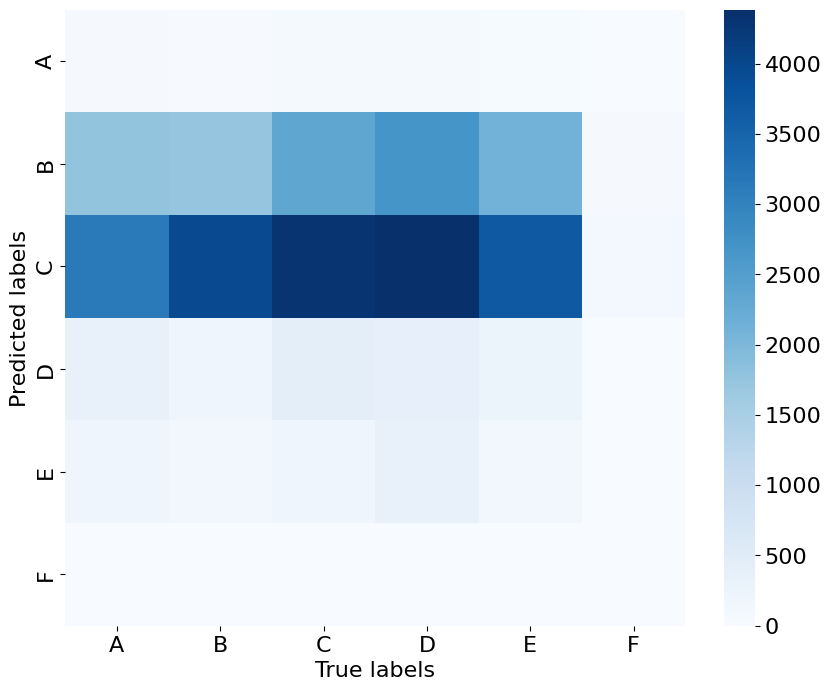

In [45]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### BiLSTM

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [47]:
#model.save('BiLSTM')
model = tfk.models.load_model('BiLSTM_classifier')

In [48]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

1040/1040 [==============================] - 9s 8ms/step


(33257, 6)

Accuracy: 0.2187
Precision: 0.1236
Recall: 0.1641
F1: 0.0862


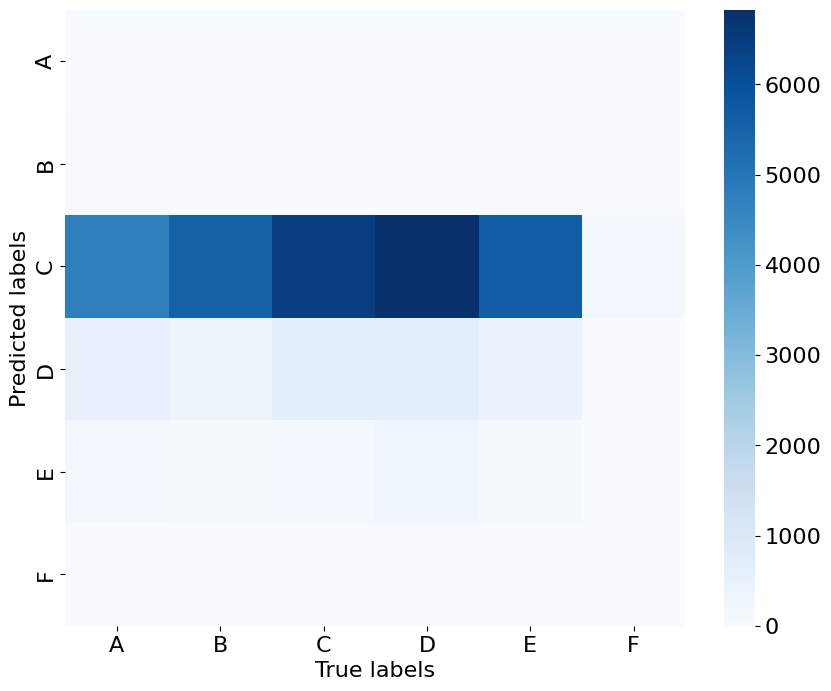

In [49]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### 1D CNN

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [50]:
#model.save('1DCNN')
model = tfk.models.load_model('1DCNN_classifier')

In [51]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

1040/1040 [==============================] - 8s 7ms/step


(33257, 6)

Accuracy: 0.2187
Precision: 0.1236
Recall: 0.1641
F1: 0.0862


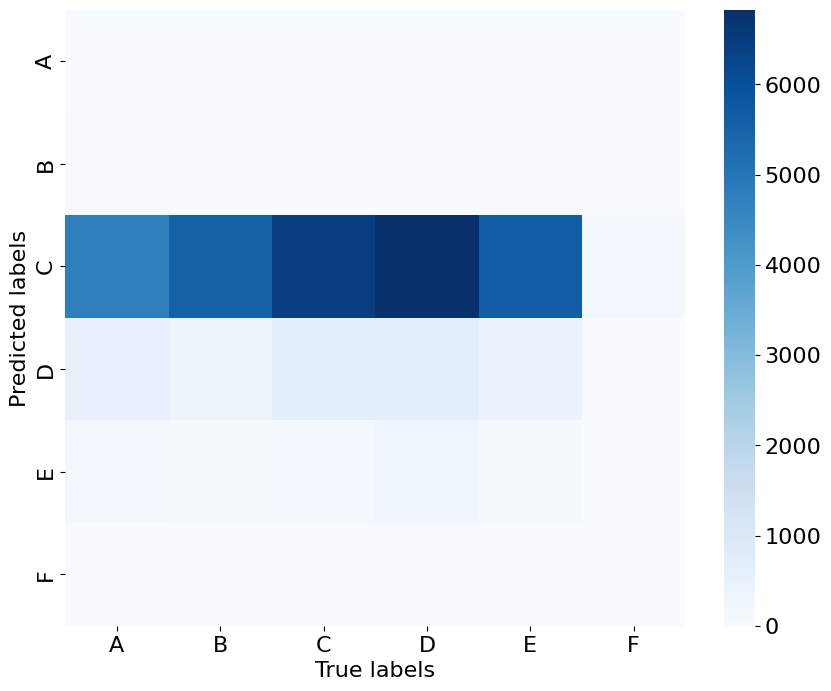

In [52]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### 1D Deeper CNN

In [53]:
model.save('1DCNN_deeper_classifier')
model = tfk.models.load_model('1DCNN_deeper_classifier')

In [54]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

1040/1040 [==============================] - 9s 8ms/step


(33257, 6)

Accuracy: 0.2187
Precision: 0.1236
Recall: 0.1641
F1: 0.0862


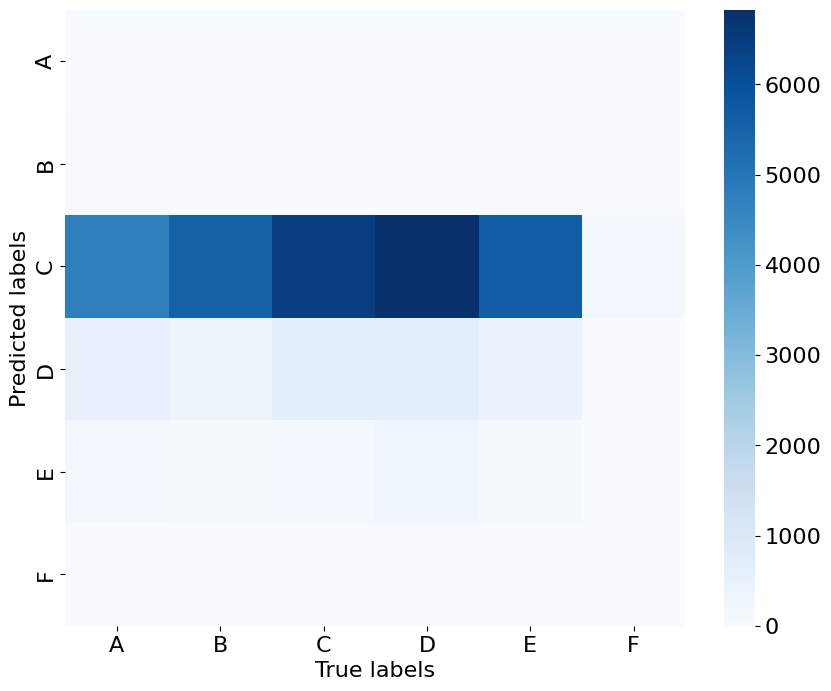

In [55]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### VGG style conv1d

In [ ]:
# Define a convolutional block with batch normalization option
def conv_bn_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling1D(name='MaxPool_' + name)(x)

    # Apply a stack of convolutional layers with optional batch normalization and specified activation
    for s in range(stack):
        x = tfkl.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x)
        if batch_norm:
            x = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x)
        x = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x)

    return x

In [ ]:
# Define a function to build a VGG18-like model with batch normalization
def build_bn_model(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv1D(filters=64, kernel_size=3, padding='same', name='Conv0')(input_layer)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create convolutional blocks with batch normalization
    x1 = conv_bn_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='1')
    x1 = conv_bn_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='2')

    x2 = conv_bn_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='3')
    x2 = conv_bn_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='4')

    x3 = conv_bn_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='5')
    x3 = conv_bn_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='6')

    x4 = conv_bn_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='7')
    x4 = conv_bn_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling1D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_BN')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [ ]:
bn_model = build_bn_model()
bn_model.summary()
tfk.utils.plot_model(bn_model, expand_nested=True, show_shapes=True)

In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
]

In [ ]:
X_train.shape, y_train.shape

In [ ]:
bn_history = bn_model.fit(
    X_train,
    y_train,
    validation_data = (X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks,
    class_weight=class_weights
).history

In [56]:
#bn_model.save('VGG_classifier')
model = tfk.models.load_model('VGG_classifier')

In [57]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

1040/1040 [==============================] - 8s 5ms/step


(33257, 6)

In [ ]:
plt.plot(X_test[150])

Accuracy: 0.539
Precision: 0.4998
Recall: 0.5101
F1: 0.502


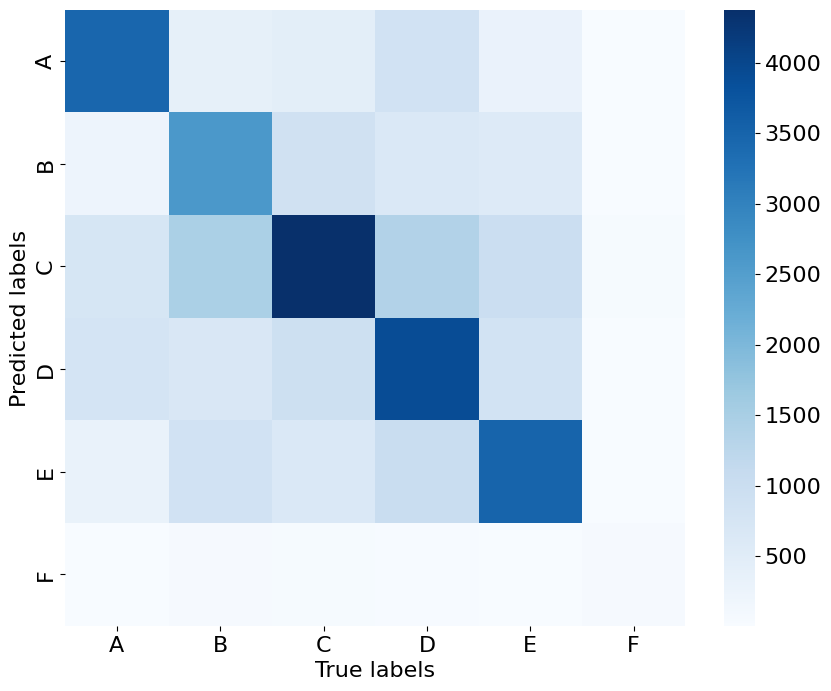

In [58]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### ResNet 1D

In [ ]:
# Define a residual convolutional block with optional batch normalization
def conv_residual_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling1D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv1D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
# Define a function to build a VGG18-like model with residual blocks
def build_model_residual(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv1D(filters=64, kernel_size=3, padding='same', name='Conv0')(input_layer)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create residual blocks
    x1 = conv_residual_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_residual_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_residual_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_residual_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_residual_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_residual_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_residual_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_residual_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling1D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_Residual')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [ ]:
residual_model = build_model_residual()
residual_model.summary()
tfk.utils.plot_model(residual_model, expand_nested=True, show_shapes=True)

In [ ]:
residual_history = residual_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks,
    class_weight = class_weights
).history

In [ ]:
# Plot validation loss for different models
plt.figure(figsize=(15, 3))
#plt.plot(baseline_history['val_loss'], label='VGG18', alpha=0.8, color='#ff7f0e')
plt.plot(bn_history['val_loss'], label='VGG18+BN', alpha=0.8, color='#1B87B5')
plt.plot(residual_history['val_loss'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot validation accuracy for different models
plt.figure(figsize=(15, 3))
#plt.plot(baseline_history['val_accuracy'], label='VGG18', alpha=0.8, color='#ff7f0e')
plt.plot(bn_history['val_accuracy'], label='VGG18+BN', alpha=0.8, color='#1B87B5')
plt.plot(residual_history['val_accuracy'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Show the plots
plt.show()

In [ ]:
residual_model.save('residual_model_classifier')
del residual_model

In [ ]:
model = tfk.models.load_model('residual_model_classifier')

In [ ]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### ResNet 1D with masking

In [ ]:
# Define a residual convolutional block with optional batch normalization
def conv_residual_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling1D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv1D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
# Define a function to build a VGG18-like model with residual blocks
def build_model_residual(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    mask = tfkl.Masking(mask_value=0.0)(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv1D(filters=64, kernel_size=3, padding='same', name='Conv0')(mask)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create residual blocks
    x1 = conv_residual_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_residual_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_residual_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_residual_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_residual_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_residual_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_residual_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_residual_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling1D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_Residual')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [ ]:
residual_model = build_model_residual()
residual_model.summary()
tfk.utils.plot_model(residual_model, expand_nested=True, show_shapes=True)

In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
]

In [ ]:
residual_history = residual_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks,
    class_weight = class_weights
).history

In [ ]:
# Plot validation loss for different models
plt.figure(figsize=(15, 3))
#plt.plot(baseline_history['val_loss'], label='VGG18', alpha=0.8, color='#ff7f0e')
#plt.plot(bn_history['val_loss'], label='VGG18+BN', alpha=0.8, color='#1B87B5')
plt.plot(residual_history['val_loss'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot validation accuracy for different models
plt.figure(figsize=(15, 3))
#plt.plot(baseline_history['val_accuracy'], label='VGG18', alpha=0.8, color='#ff7f0e')
#plt.plot(bn_history['val_accuracy'], label='VGG18+BN', alpha=0.8, color='#1B87B5')
plt.plot(residual_history['val_accuracy'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Show the plots
plt.show()

In [ ]:
residual_model.save('residual_model_masking_classifier')
del residual_model

In [59]:
model = tfk.models.load_model('residual_model_masking_classifier')

In [60]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

1040/1040 [==============================] - 6s 5ms/step


(33257, 6)

In [61]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy: 0.5448
Precision: 0.4862
Recall: 0.517
F1: 0.493


### LSTM + 1DCNN

In [62]:
model1 = tfk.models.load_model('LSTM_classifier')
model2 = tfk.models.load_model('VGG_classifier')
model3 = tfk.models.load_model('residual_model_masking_classifier')

In [63]:
# Predict the test set with the 1DCNN
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)
predictions3 = model3.predict(X_test)
predictions1.shape
predictions2.shape
predictions3.shape

1040/1040 [==============================] - 6s 5ms/step


(33257, 6)

Accuracy: 0.1986
Precision: 0.1602
Recall: 0.1584
F1: 0.1106


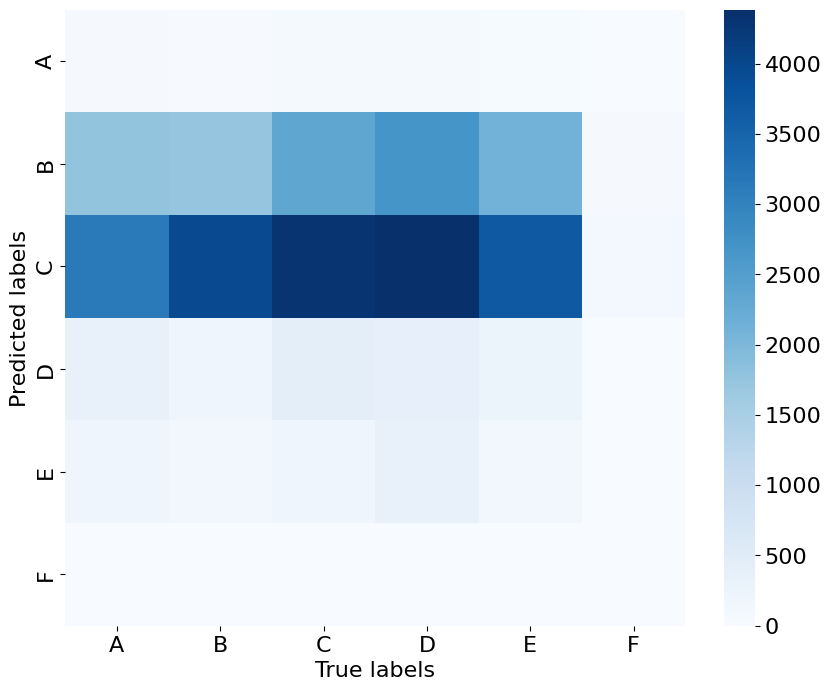

In [64]:
predictions = predictions1
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy: 0.539
Precision: 0.4998
Recall: 0.5101
F1: 0.502


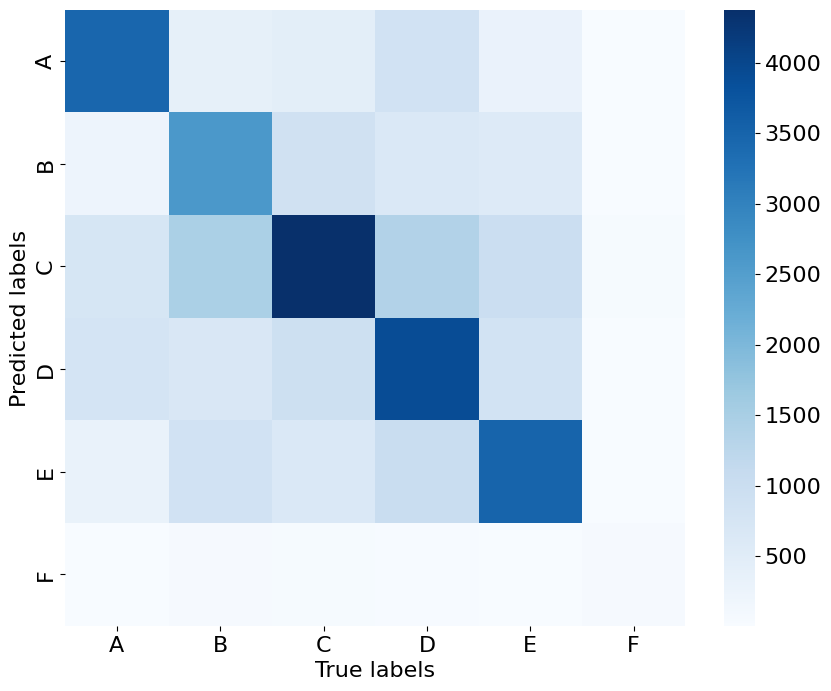

In [65]:
predictions = predictions2
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions2, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Accuracy: 0.5448
Precision: 0.4862
Recall: 0.517
F1: 0.493


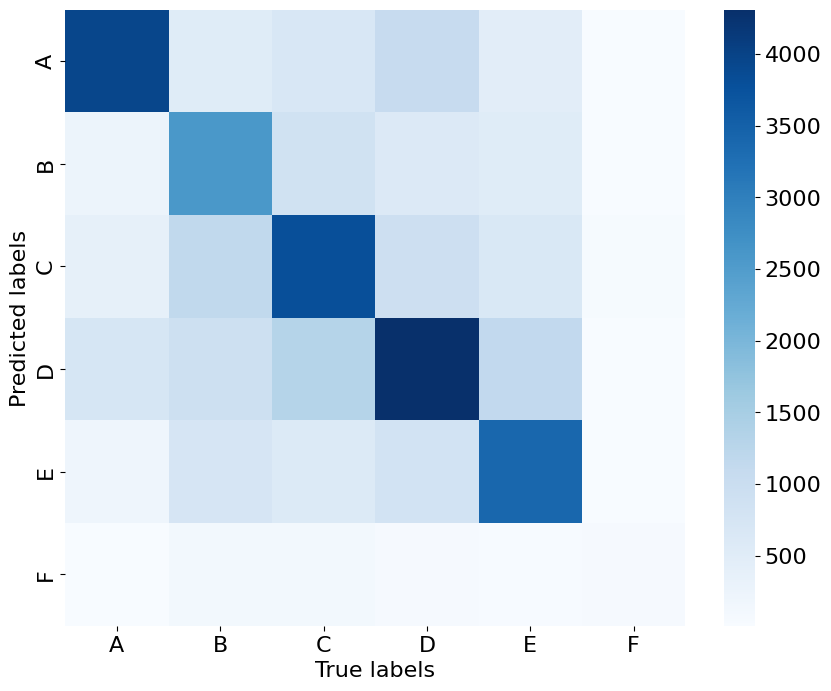

In [66]:
predictions = predictions3
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions3, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

freeze all layers

In [ ]:
for layer in lstm_model.layers:
    layer.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
for layer in res_model.layers:
    layer.trainable = False

In [ ]:
def build_big_classifier(model1, model2, model3):
  # Define input layer
  input_layer = tfkl.Input(shape=(input_shape))  # Replace input_shape with the actual input shape of your models

  # Connect input layer to the pretrained models
  output1 = model1(input_layer)
  output2 = model2(input_layer)
  output3 = model3(input_layer)

  # Concatenate the outputs of the pretrained models
  concatenated_outputs = tfkl.concatenate([output1, output2, output3])  # Use the appropriate axis parameter if needed

  # Add a dense classifier layer
  classifier_output = tfkl.Dense(6, activation='relu')(concatenated_outputs)  # Adjust the number of units as needed

  # Add additional layers if desired
  # Example: additional_output = Dense(32, activation='relu')(classifier_output)

  # Create the new model
  new_model = tf.keras.Model(inputs=input_layer, outputs=classifier_output)

  # Compile the model with an appropriate optimizer and loss
  new_model.compile(optimizer='adam', loss=tfk.losses.CategoricalCrossentropy())

  # Print the summary to check the architecture
  new_model.summary()

  return new_model

In [ ]:
big_model = build_big_classifier(lstm_model, vgg_model, res_model)

In [ ]:
big_model.layers

In [ ]:
big_model.layers[0].trainable = False
big_model.layers[1].trainable = False
big_model.layers[2].trainable = False
big_model.layers[3].trainable = False
big_model.layers[4].trainable = True
big_model.layers[5].trainable = True

In [ ]:
big_model.layers[2].layers

In [ ]:
big_model.summary()

In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
]

In [ ]:
big_history = big_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks,
    class_weight = class_weights
).history

In [ ]:
big_model.save('big_model_classifier')
del big_model

In [ ]:
model = tfk.models.load_model('big_model_classifier')

In [ ]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Transformer

In [51]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = tfkl.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [52]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tfkl.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)
    outputs = tfkl.Dense(6, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

In [53]:
y_train.shape

(66823, 6)

In [54]:
y_train[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [55]:
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["categorical_accuracy"],
)
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test, y_test, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 multi_head_attention_4 (Mu  (None, 200, 1)               7169      ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 200, 1)               0         ['multi_head_attention_4[0][0]
                                                                    ']                            
                                                                                            

[1.3807122707366943, 0.4645037055015564]

In [56]:
model.save('transformer_classifier_2')

In [57]:
# Predict the test set
predictions = model.predict(X_test)
predictions.shape

1040/1040 [==============================] - 8s 7ms/step


(33257, 6)

Accuracy: 0.4645
Precision: 0.5845
Recall: 0.3831
F1: 0.3847


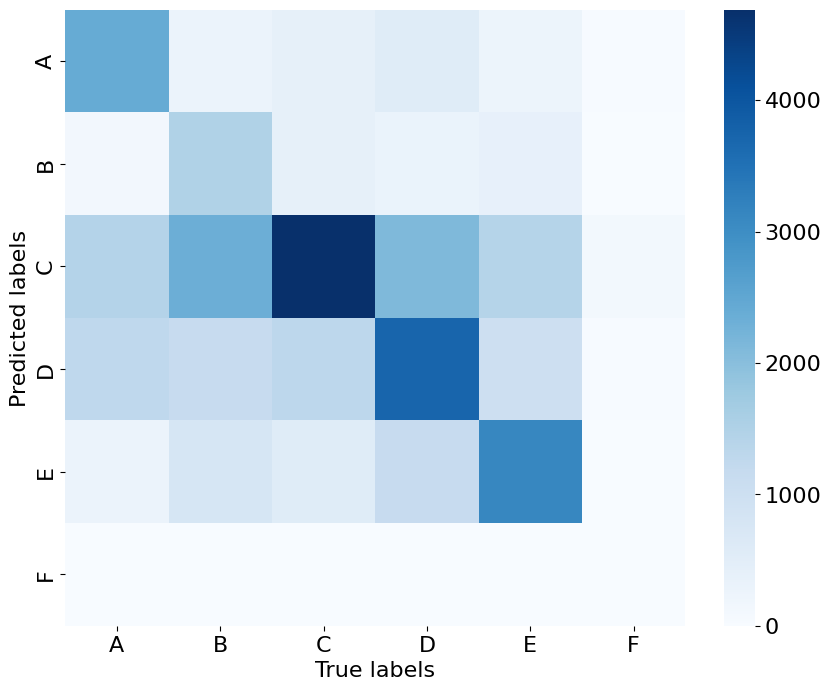

In [58]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(category_mapping), yticklabels=list(category_mapping))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Embedding Experiments

## Embedding (???)

In [ ]:
input_shape = (200,1) #X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [ ]:
def autoencoder(input_shape):
  # Assuming input_layer is your input tensor
  input_layer = tfkl.Input(shape=input_shape)

  # Downsample
  cnn = tfkl.Conv1D(32, 3, padding='same', activation='relu')(input_layer)
  cnn = tfkl.MaxPooling1D(2, padding='same')(cnn)
  cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu')(cnn)
  cnn = tfkl.MaxPooling1D(2, padding='same')(cnn)
  cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
  #gap = tfkl.GlobalAveragePooling1D()(cnn)

  # embedding
  cnn = tfkl.Dense(64)(cnn)

  # Upsample
  cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu')(cnn)
  cnn = tfkl.UpSampling1D(2)(cnn)
  cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu')(cnn)
  cnn = tfkl.UpSampling1D(2)(cnn)
  decoded = tfkl.Conv1D(1, 3, padding='same', activation='sigmoid')(cnn)

  # Build the model
  autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoded)
  autoencoder.compile(optimizer='adam', loss='mean_squared_error')

  return autoencoder

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d_39 (Conv1D)          (None, 200, 32)           128       
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 100, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_40 (Conv1D)          (None, 100, 64)           6208      
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 50, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_41 (Conv1D)          (None, 50, 128)           247

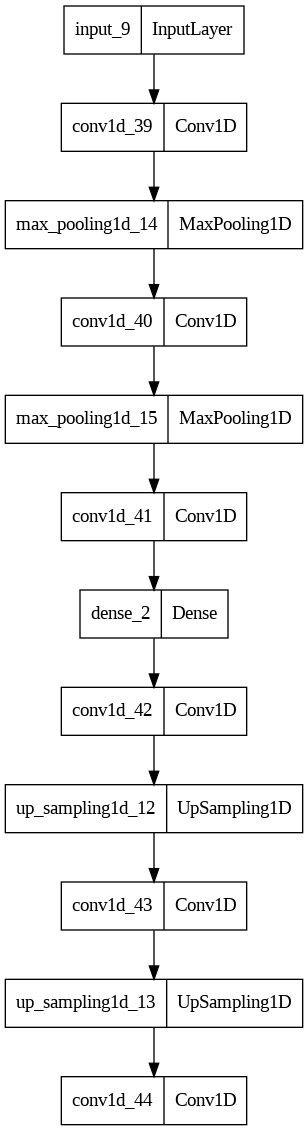

In [ ]:
model = autoencoder(input_shape)
model.summary()
tfk.utils.plot_model(model)

In [ ]:
history = model.fit(
    X_train,
    X_train,
    epochs=5,
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/5
484/484 [==============================] - 14s 24ms/step - loss: 0.0033 - val_loss: 5.1634e-04 - lr: 0.0010
Epoch 2/5
484/484 [==============================] - 11s 23ms/step - loss: 4.3610e-04 - val_loss: 1.6806e-04 - lr: 0.0010
Epoch 3/5
484/484 [==============================] - 11s 22ms/step - loss: 1.9630e-04 - val_loss: 1.2084e-04 - lr: 0.0010
Epoch 4/5
484/484 [==============================] - 11s 22ms/step - loss: 1.3735e-04 - val_loss: 8.8066e-05 - lr: 0.0010
Epoch 5/5
484/484 [==============================] - 11s 22ms/step - loss: 1.1023e-04 - val_loss: 7.1430e-05 - lr: 0.0010


7/7 [==============================] - 0s 3ms/step


ValueError: ignored

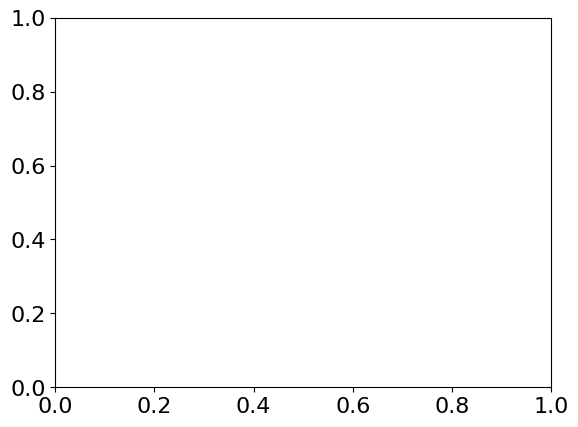

In [ ]:
out = model.predict(first_signal)
plt.plot(out)

In [ ]:
model.save('1D_CNN_Autoencoder')
autoencoder = tfk.models.load_model('1D_CNN_Autoencoder')

In [ ]:
# Get the list of layers in the model
all_layers = model.layers

# Create a list to store the individual layer models
individual_layer_models = []

# Create a new model for each layer
for i in range(len(all_layers)):
    # Create a model with the same input as the original model
    input_layer = model.input
    output_layer = all_layers[i].output
    individual_layer_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Append the individual layer model to the list
    individual_layer_models.append(individual_layer_model)

# Now you can use each individual_layer_model to compute the output of a specific layer
# For example, using the first layer as an illustration
#input_data =
#input_data = tf.constant(...)  # Provide your input data here
#output_of_first_layer = individual_layer_models[0](input_data)

# Similarly, you can use other individual_layer_models to compute the output of other layers


In [ ]:
individual_layer_models[6].summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d_27 (Conv1D)          (None, 200, 128)          512       
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 100, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_28 (Conv1D)          (None, 100, 256)          98560     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 50, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_29 (Conv1D)          (None, 50, 512)           393

In [ ]:
encoder = individual_layer_models[5]

In [ ]:
first_signal = np.reshape(X_train[0], (200,1))
first_signal_output = encoder(first_signal)

In [ ]:
first_signal_output[:,0,0].shape

TensorShape([200])

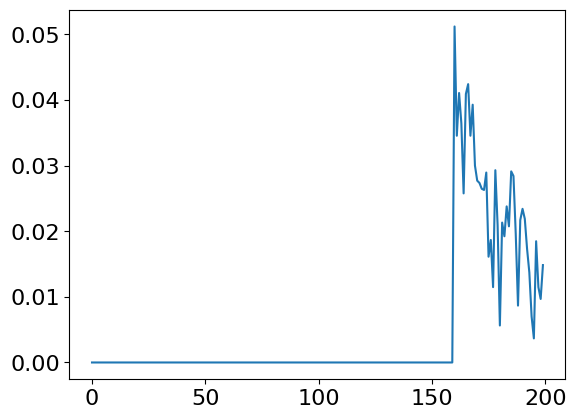

In [ ]:
plt.plot(first_signal_output[:,0,0].numpy())

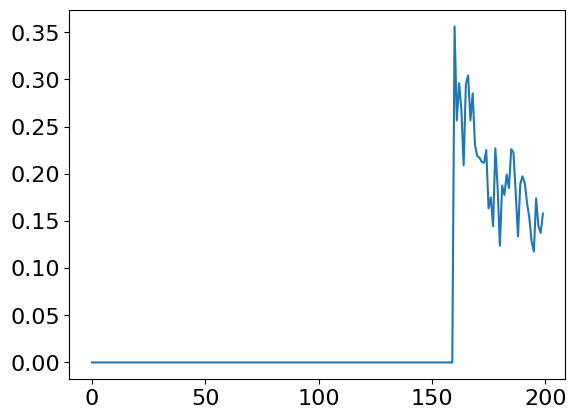

In [ ]:
plt.plot(first_signal)

In [ ]:
first_signal_decoded = autoencoder(first_signal)

In [ ]:
autoencoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d_27 (Conv1D)          (None, 200, 128)          512       
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 100, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_28 (Conv1D)          (None, 100, 256)          98560     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 50, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_29 (Conv1D)          (None, 50, 512)           393

In [ ]:
first_signal_decoded.shape

TensorShape([200, 4, 1])

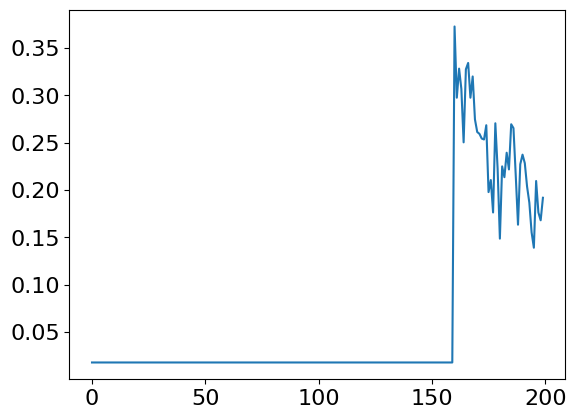

In [ ]:
plt.plot(first_signal_decoded[:,0,0])

In [ ]:
# first, try a known signal as input data and find its learned representation
# then plot the result of the autoencoder

In [ ]:
def analyze_signal(signal, autoencoder, encoder):
  encoded = encoder(signal)
  decoded = autoencoder(signal)

In [ ]:
# then try a second signal and do the same

In [ ]:
# then try a bunch of coordinates going from one to another and plot the results

In [ ]:
# now we have to perform clustering, shit

## spectral analysis (???)

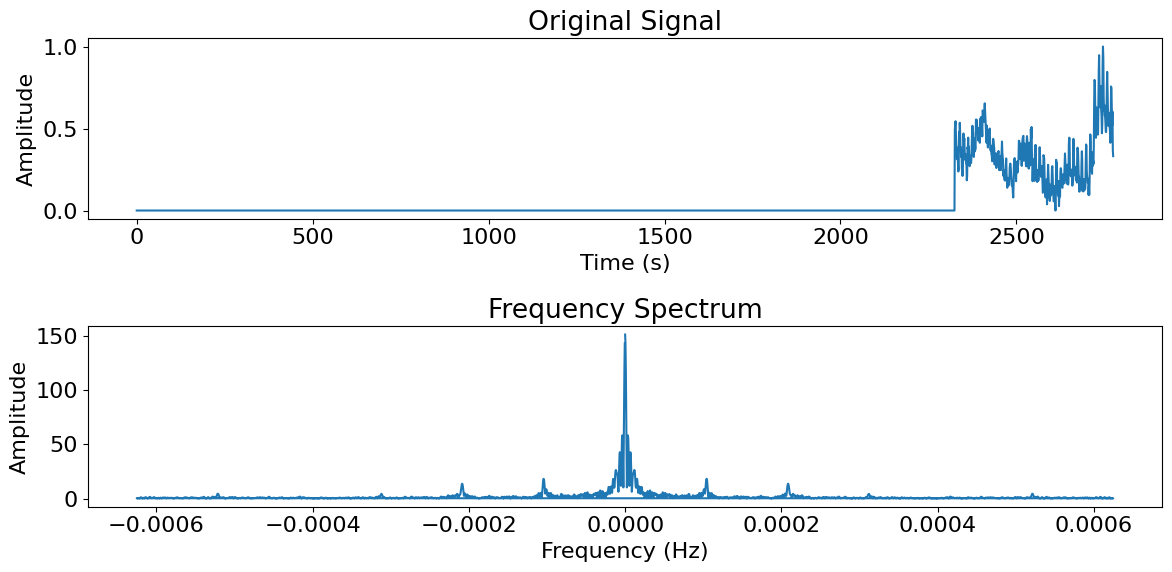

In [ ]:
# primo segnale
signal = dataset[0]
fs = 1/800

fft_result = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(signal), 1/fs)

# Plot the original signal and its frequency spectrum
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(fft_freq, np.abs(fft_result))
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [ ]:
# secondo segnale
signal = dataset[1]
fs = 1/800

fft_result = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(signal), 1/fs)

# Plot the original signal and its frequency spectrum
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(fft_freq, np.abs(fft_result))
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

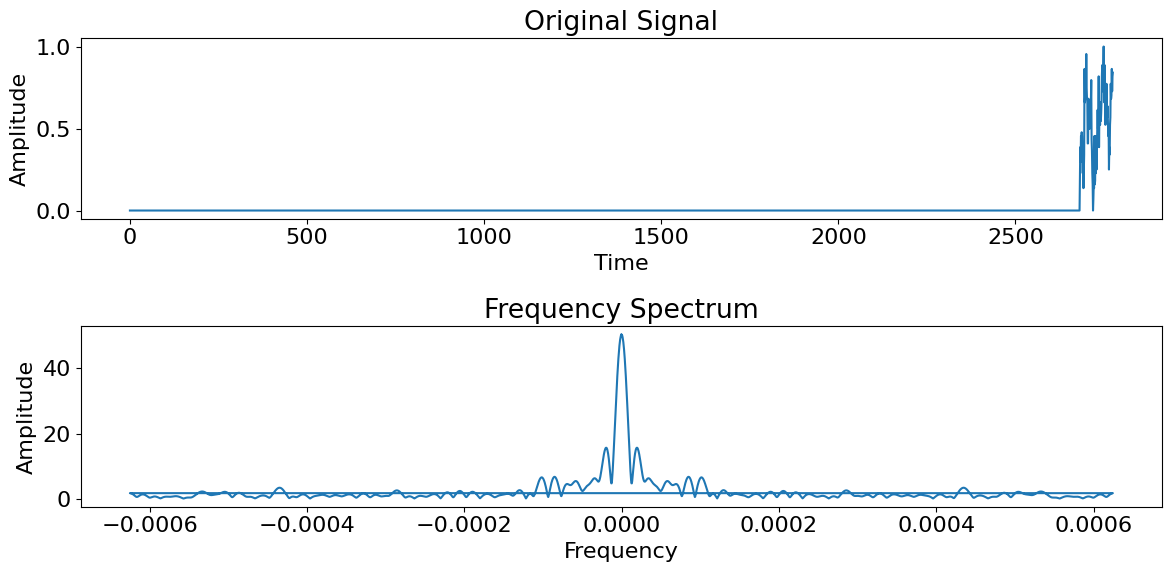

In [ ]:
# primo segnale
from scipy.fft import fft
signal = dataset[4]
fs = 10000

fft_result = fft(signal)
#fft_freq = np.fft.fftfreq(len(signal), 1/fs)

# Plot the original signal and its frequency spectrum
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(fft_freq, np.abs(fft_result))
plt.title('Frequency Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [ ]:
fft_freq

array([ 0.00000000e+00,  4.50288184e-07,  9.00576369e-07, ...,
       -1.35086455e-06, -9.00576369e-07, -4.50288184e-07])

In [ ]:
import numpy as np

def max_significant_fs(signals, duration=1):
    """
    Calculate the maximum significant sampling frequency for a list of signals.

    Parameters:
    - signals: List of numpy arrays representing signals.
    - duration: Duration of each signal in seconds.

    Returns:
    - max_fs: Maximum significant sampling frequency.
    """
    max_freqs = []

    for signal in signals:
        # Perform FFT to find the frequency content
        fft_result = np.fft.fft(signal)
        fft_freq = np.fft.fftfreq(len(signal), duration/len(signal))

        # Identify the maximum significant frequency (excluding DC component)
        max_freq = np.max(np.abs(fft_freq[1:]))
        max_freqs.append(max_freq)

    # Choose the maximum among the maximum frequencies of all signals
    max_fs = 2 * np.max(max_freqs)

    return max_fs

# Example usage:

# Calculate the maximum significant sampling frequency
max_fs = max_significant_fs(dataset, duration=2776)
print("Maximum Significant Sampling Frequency:", max_fs, "Hz")


Maximum Significant Sampling Frequency: 0.9999999999999999 Hz


fs = 1

### spectrograms

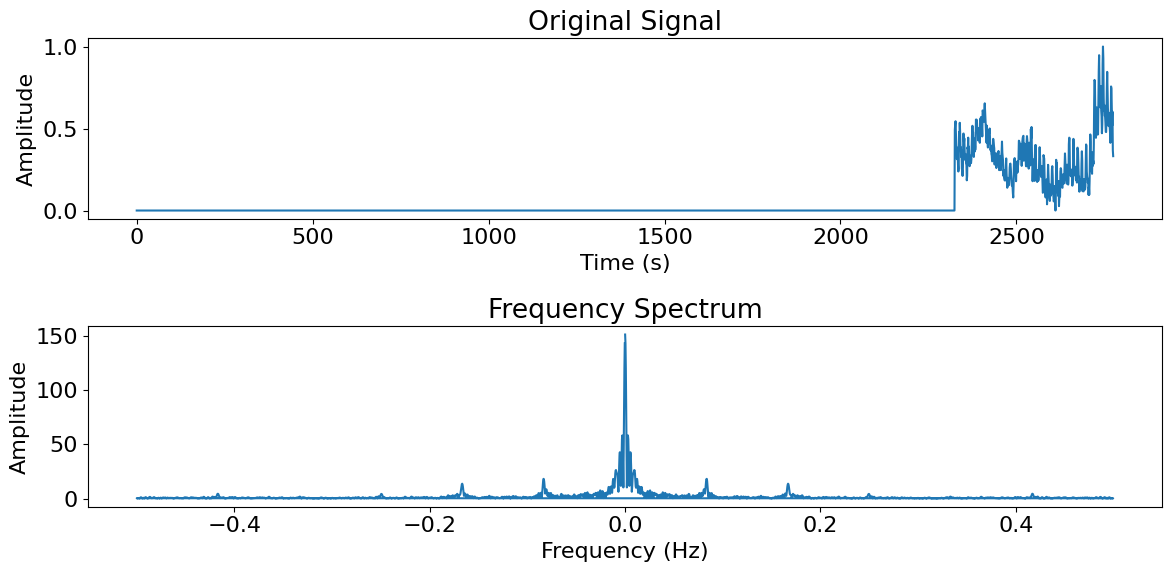

In [ ]:
# primo segnale
signal = dataset[0]
fs = 1

fft_result = np.fft.fft(signal)
fft_freq = np.fft.fftfreq(len(signal), 1/fs)

# Plot the original signal and its frequency spectrum
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(fft_freq, np.abs(fft_result))
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
# Generate example signal
fs = 2

# primo segnale
signal = dataset[3]
#fs = 1/800

# Create a spectrogram
plt.figure(figsize=(10, 6))
plt.specgram(signal, Fs=fs, cmap='viridis', NFFT=256, noverlap=128)
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB/Hz)')
plt.show()


# Forecasting

## Data Preprocessing for Forecasting

Sequential Train-Test split and normalization

TODO:

inserire normalizzazione allìinterno del modello

splittare le window con l'autocorrelazione

migliorare gli ultimi layer del modello di marco

splittare il dataset per lunghezza e vedere se migliora

In [19]:
dataset = np.array(list_of_signals)
dataset.shape

(48000,)

In [20]:
long_signals = list()
short_signals = list()

for elem in dataset:
  if elem.shape[0] < 200:
    short_signals.append(elem)
  else:
    long_signals.append(elem)

print(len(short_signals))
print(len(long_signals))

24943
23057


In [21]:
long_short_signals = list()
short_short_signals = list()

for elem in short_signals:
  if elem.shape[0] < 100:
    short_short_signals.append(elem)
  else:
    long_short_signals.append(elem)

print(len(short_short_signals))
print(len(long_short_signals))

15395
9548


In [22]:
long_long_signals = list()
short_long_signals = list()

for elem in long_signals:
  if elem.shape[0] < 290:
    short_long_signals.append(elem)
  else:
    long_long_signals.append(elem)

print(len(short_long_signals))
print(len(long_long_signals))

15086
7971


In [23]:
'''
# robust scaling of the signals
from sklearn.preprocessing import RobustScaler

# Create a RobustScaler instance
scaler = RobustScaler()

scaled_signals = list()

for i in range(len(list_of_signals)):
    original_data = list_of_signals[i].reshape(-1, 1)
    # Fit and transform the data
    scaled_data = scaler.fit_transform(original_data)
    scaled_signals.append(np.squeeze(scaled_data, axis=1))
    # Extract the parameters
    median = scaler.center_[0]
    iqr = scaler.scale_[0]
    # Invert the transformation
    inverted_data = (scaled_data * iqr) + median

dataset = np.array(scaled_signals)
dataset.shape
'''

'\n# robust scaling of the signals\nfrom sklearn.preprocessing import RobustScaler\n\n# Create a RobustScaler instance\nscaler = RobustScaler()\n\nscaled_signals = list()\n\nfor i in range(len(list_of_signals)):\n    original_data = list_of_signals[i].reshape(-1, 1)\n    # Fit and transform the data\n    scaled_data = scaler.fit_transform(original_data)\n    scaled_signals.append(np.squeeze(scaled_data, axis=1))\n    # Extract the parameters\n    median = scaler.center_[0]\n    iqr = scaler.scale_[0]\n    # Invert the transformation\n    inverted_data = (scaled_data * iqr) + median\n\ndataset = np.array(scaled_signals)\ndataset.shape\n'

In [24]:
test_prop = 0.2

X_train_raw = list()
X_test_raw = list()

for i in range(len(dataset)):
  test_index = int((1 - test_prop) * len(dataset[i]))
  X_train_raw.append(dataset[i][:test_index])
  X_test_raw.append(dataset[i][test_index:])

X_train_raw = np.array(X_train_raw)
X_test_raw = np.array(X_test_raw)

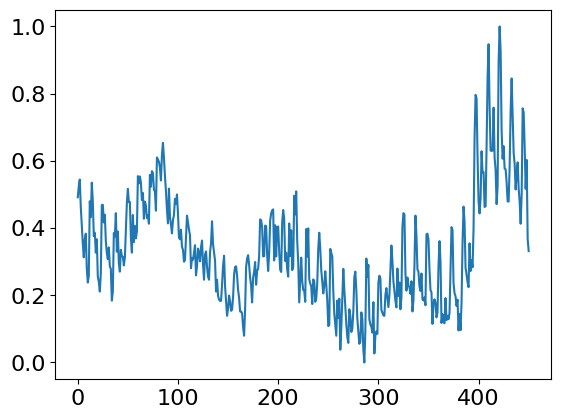

In [25]:
plt.plot(dataset[0])

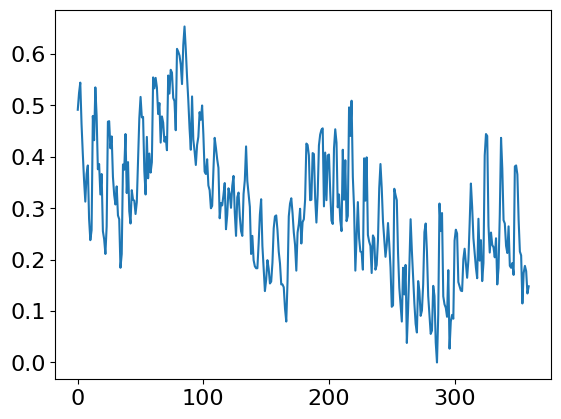

In [26]:
plt.plot(X_train_raw[0])

In [27]:
X_train_raw.shape, X_test_raw.shape

((48000,), (48000,))

In [28]:
from scipy.signal import find_peaks

time_series = dataset[1000]

# Compute autocorrelation
autocorrelation = np.correlate(time_series, time_series, mode='full')

# Find peaks in autocorrelation
peaks, _ = find_peaks(autocorrelation)

# Plot the time series and autocorrelation
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time_series)
plt.title('Original Time Series')

plt.subplot(2, 1, 2)
plt.plot(autocorrelation)
plt.plot(peaks, autocorrelation[peaks], 'ro')  # Mark peaks
plt.title('Autocorrelation Function with Peaks')

plt.tight_layout()
plt.show()


In [29]:
window = 200
stride = 50 # mettere stride 1
telescope = 9

def build_sequences_forecasting(X, window, telescope, stride):
  new_X = []
  new_dataset = []
  new_labels_dataset = []
  new_X_noise = []
  for seq in X:
    padding_check = len(seq)%window
    n_of_windows = len(seq)//window
    if padding_check != 0:
      padding_len = window*(n_of_windows+1) + telescope - len(seq)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, seq))
    new_X.append(temp_unit)


  for i in range(len(new_X)):
      seq = new_X[i]
      # Compute autocorrelation
      autocorrelation = np.correlate(seq, seq, mode='full')
      # Find peaks in autocorrelation
      peaks, _ = find_peaks(autocorrelation)

      if seq.shape[0] == window+telescope:
        end = 1
      else:
        end = seq.shape[0]-window-telescope

      peaks = [peak > telescope and peak < end for peak in peaks]

      if(len(peaks) == 0):
        print('error dim peak 0')

      for idx in range(0, end, stride):
          elem = np.array(new_X[i][idx:idx+window])
          lab = np.array(new_X[i][idx+window:idx+window+telescope]) # prediction labels
          new_dataset.append(elem)
          new_labels_dataset.append(lab)
          if elem.shape != (window,):
            print("error at index:")
            print(idx)

  new_dataset = np.array(new_dataset)
  new_labels_dataset = np.array(new_labels_dataset)

  return new_dataset, new_labels_dataset

In [30]:
X_train, y_train = build_sequences_forecasting(X_train_raw, window, telescope, stride)
X_test, y_test = build_sequences_forecasting(X_test_raw, window, telescope, stride)

In [31]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((106796, 200), (106796, 9), (48159, 200), (48159, 9))

In [32]:
def inspect_normalization(signal):
    # Reshape the signal to (length, channels) for compatibility with BatchNormalization
    signal = signal.reshape(-1, 1)

    # Build a model with Batch Normalization
    input_layer = tfkl.Input(shape=(1,))
    normalized_output = tfkl.BatchNormalization()(input_layer)
    model = tf.keras.Model(inputs=input_layer, outputs=normalized_output)

    # Apply batch normalization to the signal
    normalized_signal = model.predict(signal)

    # Plot the original and normalized signals
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(signal, label='Original Signal')
    plt.title('Original Signal')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(normalized_signal, label='Normalized Signal')
    plt.title('Normalized Signal')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

7/7 [==============================] - 1s 1ms/step


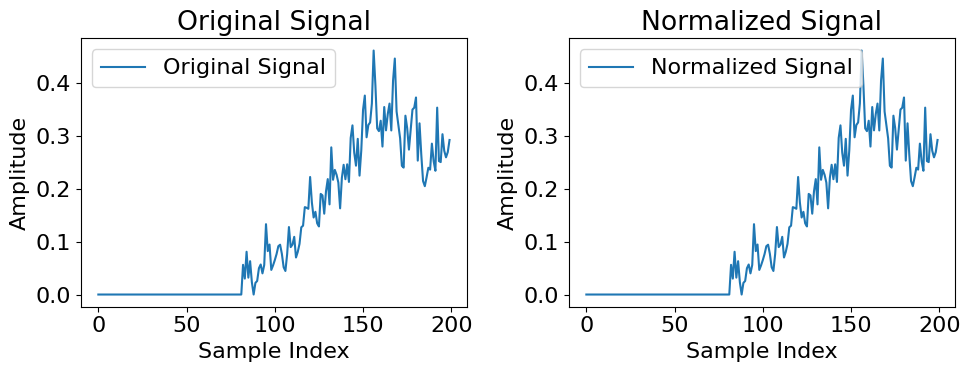

In [33]:
inspect_normalization(X_train[150])

In [34]:
direct_telescope = telescope

In [35]:
def inspect_multivariate(X, y, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.scatter(np.arange(len(X[0,:]), len(X_train[0,:])+telescope), y[idx,:], color='orange')
    #axs.set_ylim(0,1)
    plt.show()

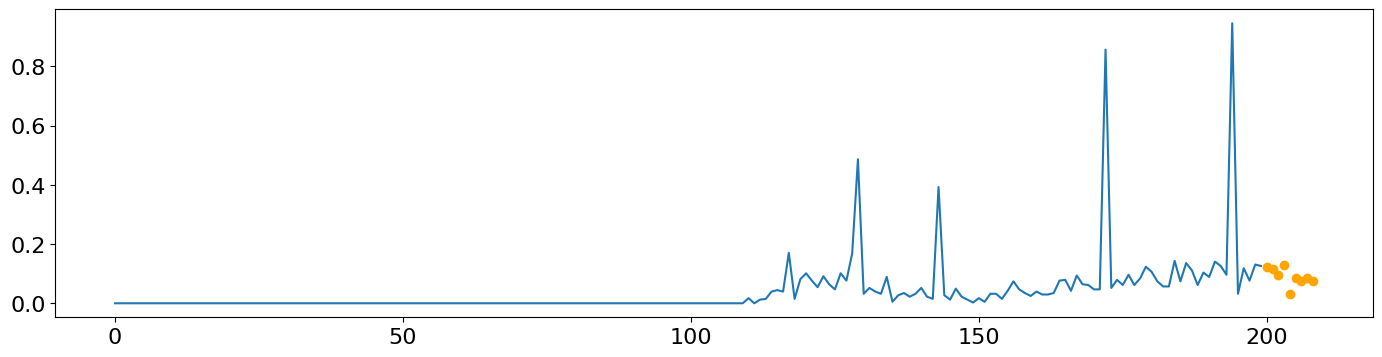

In [36]:
inspect_multivariate(X_train, y_train, direct_telescope)

In [37]:
input_shape = (X_train.shape[1],1)
output_shape = (y_train.shape[1],1)
batch_size = 64
epochs = 200

In [38]:
input_shape

(200, 1)

In [39]:
output_shape

(9, 1)

## LSTM-1

In [ ]:
def build_LSTM(input_shape):
    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    x = tfkl.Flatten()(x)

    # Add a Dense layer with 9 neurons
    x = tfkl.Dense(9, activation='relu', name='dense_layer')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=x, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
model = build_LSTM(input_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 dense_layer (Dense)         (None, 9)                 230409    
                                                                 
Total params: 264201 (1.01 MB)
Trainable params: 264201 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
1009/1009 [==============================] - 22s 18ms/step - loss: 0.0161 - val_loss: 0.0293 - lr: 0.0010
Epoch 2/200
1009/1009 [==============================] - 18s 17ms/step - loss: 0.0135 - val_loss: 0.0262 - lr: 0.0010
Epoch 3/200
1009/1009 [==============================] - 18s 17ms/step - loss: 0.0133 - val_loss: 0.0267 - lr: 0.0010
Epoch 4/200
1009/1009 [==============================] - 17s 17ms/step - loss: 0.0130 - val_loss: 0.0266 - lr: 0.0010
Epoch 5/200
1009/1009 [==============================] - 18s 17ms/step - loss: 0.0129 - val_loss: 0.0257 - lr: 0.0010
Epoch 6/200
1009/1009 [==============================] - 17s 17ms/step - loss: 0.0128 - val_loss: 0.0258 - lr: 0.0010
Epoch 7/200
1009/1009 [==============================] - 18s 17ms/step - loss: 0.0128 - val_loss: 0.0253 - lr: 0.0010
Epoch 8/200
1009/1009 [==============================] - 18s 17ms/step - loss: 0.0127 - val_loss: 0.0261 - lr: 0.0010
Epoch 9/200
1009/1009 [==============================] -

KeyboardInterrupt: ignored

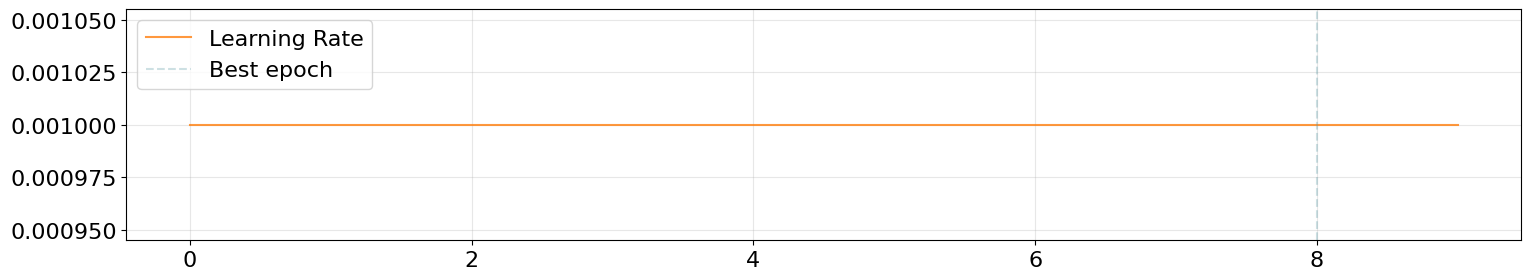

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('LSTM_1')
model = tfk.models.load_model('LSTM_1')

Test evaluation

In [ ]:
X_test.shape

(48159, 200)

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (48159, 9)
Mean Squared Error: 0.022945085540413857
Mean Absolute Error: 0.10603442788124084


In [ ]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

0.07629015677846435

In [ ]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [ ]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [ ]:
future_predictions = model.predict(future,verbose=1)

1500/1500 [==============================] - 9s 6ms/step


In [ ]:
maes.shape

(9, 1)

In [ ]:
future_predictions.shape

(48000, 9)

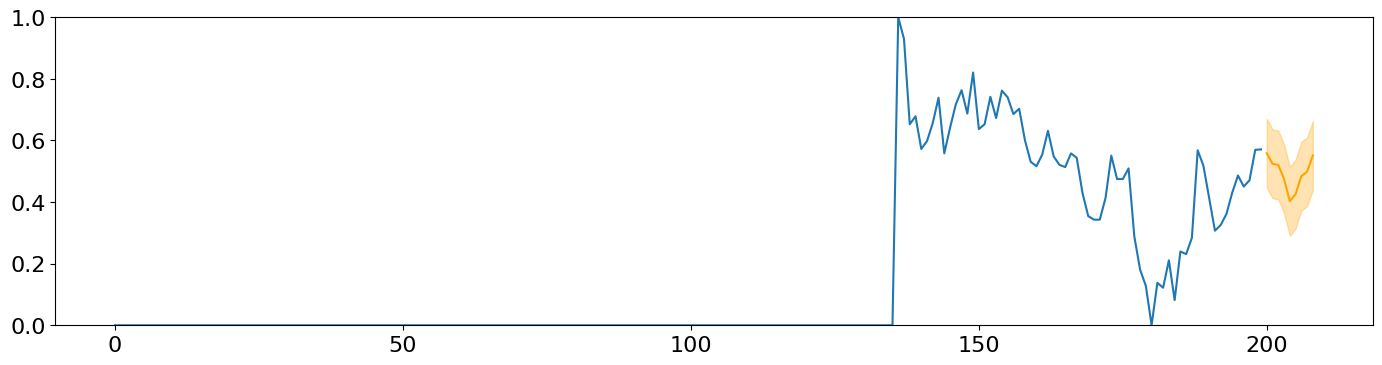

In [ ]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## LSTM-2

In [ ]:
direct_telescope = telescope

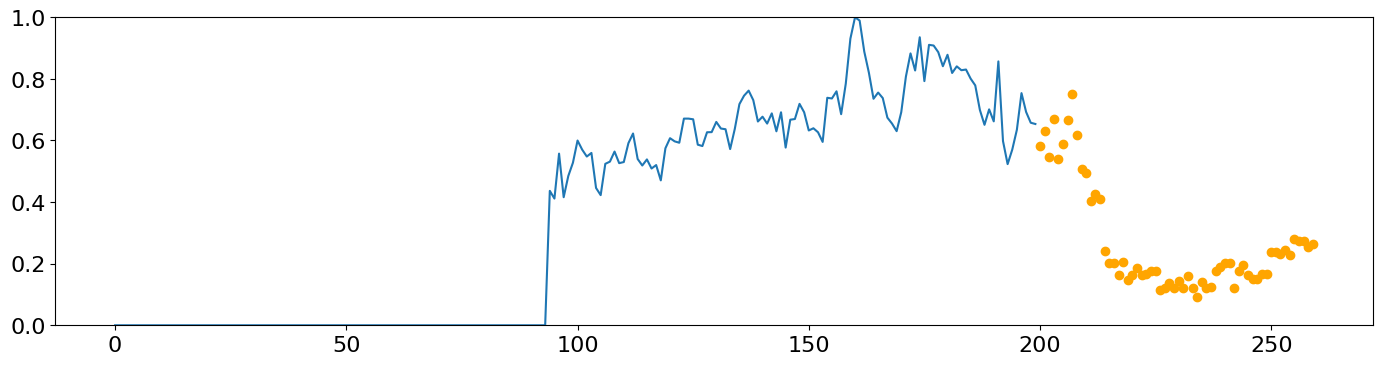

In [ ]:
inspect_multivariate(X_train, y_train, direct_telescope)

In [ ]:
input_shape = (X_train.shape[1],1)
output_shape = (y_train.shape[1],1)
batch_size = 64
epochs = 8

In [ ]:
input_shape

(200, 1)

In [ ]:
output_shape

(60, 1)

In [ ]:
def build_LSTM_with_attention(input_shape, output_shape):
    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add Attention layer
    attention_output = tfkl.Attention()([input_layer, input_layer])

    # Add a Bidirectional LSTM layer with 64 units
    lstm_output = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(attention_output)

    # Concatenate LSTM output and attention output
    #merged_output = tfkl.Concatenate(axis=-1)([lstm_output, attention_output])

    # Flatten the concatenated output
    flattened_output = tfkl.Flatten()(lstm_output)

    # Add a Dense layer with 60 neurons
    dense_output = tfkl.Dense(60, activation='relu', name='dense_layer')(flattened_output)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=dense_output, name='LSTM_with_Attention')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model


Model: "LSTM_with_Attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 attention_1 (Attention)     (None, 200, 1)               0         ['input_layer[0][0]',         
                                                                     'input_layer[0][0]']         
                                                                                                  
 bidirectional_lstm (Bidire  (None, 200, 128)             33792     ['attention_1[0][0]']         
 ctional)                                                                                         
                                                                                

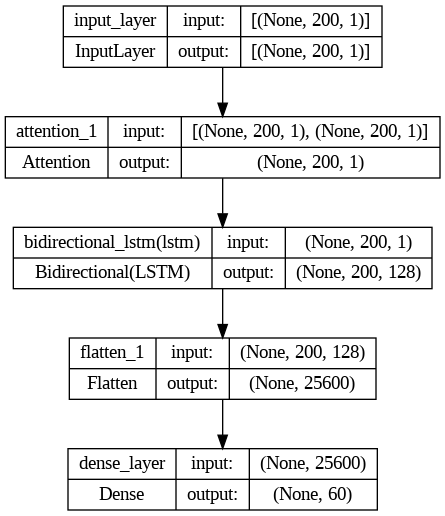

In [ ]:
model = build_LSTM_with_attention(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/8
742/742 [==============================] - 16s 16ms/step - loss: 0.0478 - val_loss: 0.0343 - lr: 0.0010
Epoch 2/8
742/742 [==============================] - 11s 15ms/step - loss: 0.0327 - val_loss: 0.0335 - lr: 0.0010
Epoch 3/8
742/742 [==============================] - 12s 16ms/step - loss: 0.0313 - val_loss: 0.0330 - lr: 0.0010
Epoch 4/8
742/742 [==============================] - 11s 15ms/step - loss: 0.0301 - val_loss: 0.0316 - lr: 0.0010
Epoch 5/8
742/742 [==============================] - 10s 14ms/step - loss: 0.0296 - val_loss: 0.0320 - lr: 0.0010
Epoch 6/8
742/742 [==============================] - 11s 15ms/step - loss: 0.0290 - val_loss: 0.0315 - lr: 0.0010
Epoch 7/8
742/742 [==============================] - 11s 15ms/step - loss: 0.0283 - val_loss: 0.0311 - lr: 0.0010
Epoch 8/8
742/742 [==============================] - 10s 14ms/step - loss: 0.0277 - val_loss: 0.0298 - lr: 0.0010


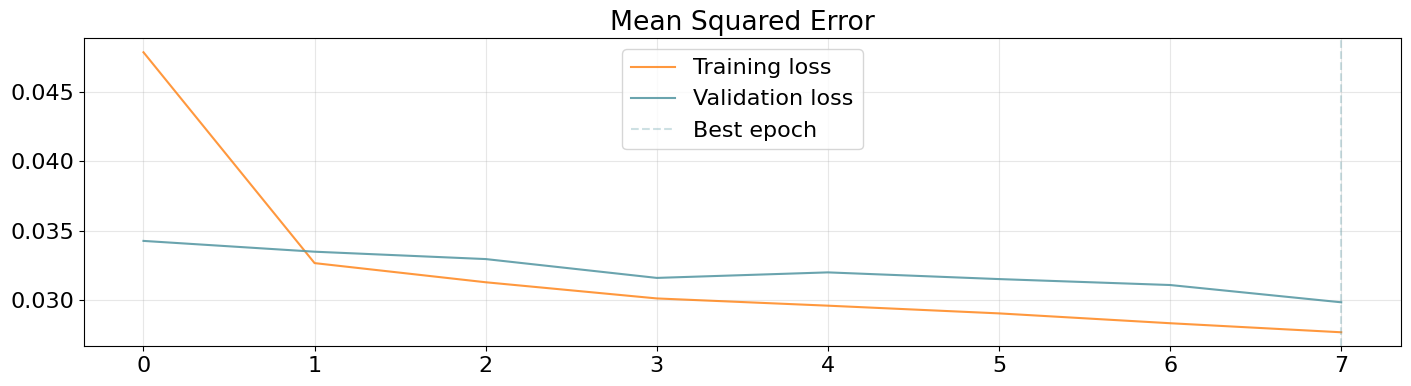

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('LSTM_2_Attention_stride_50')
model = tfk.models.load_model('LSTM_2_Attention_stride_50')

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (699, 60)
Mean Squared Error: 0.05157999321818352
Mean Absolute Error: 0.17795495688915253


In [ ]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

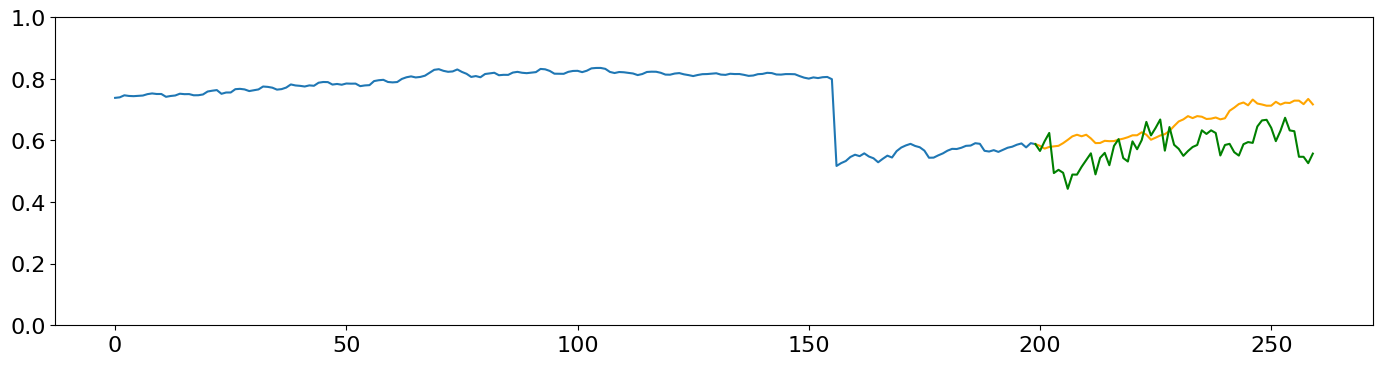

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

0.1479338750673033

In [ ]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [ ]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [ ]:
future_predictions = model.predict(future,verbose=1)

1500/1500 [==============================] - 10s 6ms/step


In [ ]:
maes.shape

(60, 1)

In [ ]:
future_predictions.shape

(48000, 60)

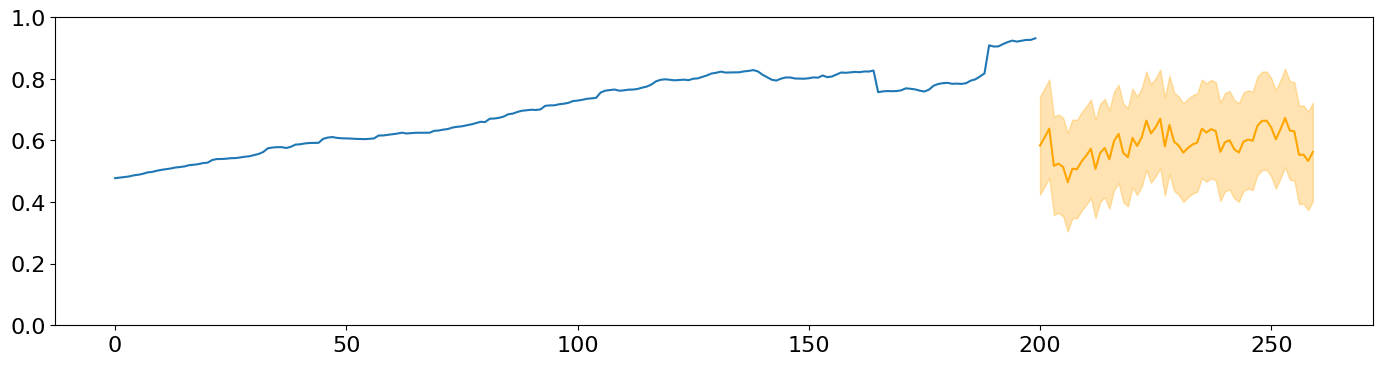

In [ ]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## LSTM-3

In [ ]:
direct_telescope = telescope

In [ ]:
input_shape = (X_train.shape[1],1)
output_shape = (y_train.shape[1],1)
batch_size = 64
epochs = 8

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[0], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    flattened_input = tfkl.Flatten()(output_layer)

    # Add a Dense layer with 60 neurons
    dense_layer = tfkl.Dense(60, activation='relu', name='dense_layer')(flattened_input)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=dense_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 200, 60)           23100     
                                                                 
 cropping (Cropping1D)       (None, 60, 60)            0         
                                                                 
 flatten_2 (Flatten)         (None, 3600)              0         
                                                   

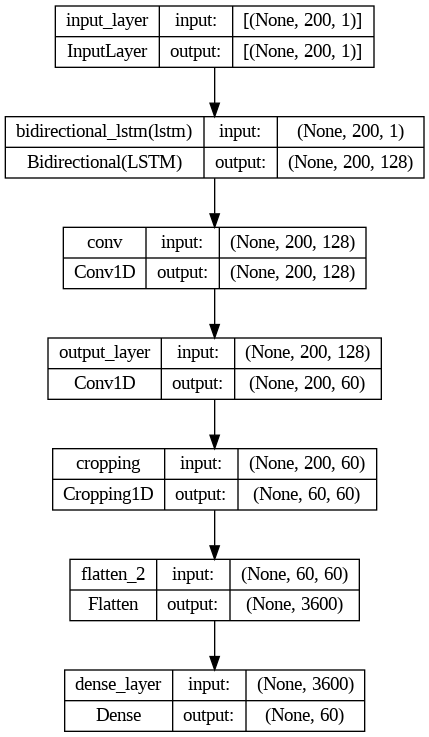

In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/8
742/742 [==============================] - 22s 18ms/step - loss: 0.0577 - val_loss: 0.0588 - lr: 0.0010
Epoch 2/8
742/742 [==============================] - 12s 16ms/step - loss: 0.0544 - val_loss: 0.0569 - lr: 0.0010
Epoch 3/8
742/742 [==============================] - 12s 16ms/step - loss: 0.0450 - val_loss: 0.0377 - lr: 0.0010
Epoch 4/8
742/742 [==============================] - 13s 17ms/step - loss: 0.0363 - val_loss: 0.0397 - lr: 0.0010
Epoch 5/8
742/742 [==============================] - 12s 16ms/step - loss: 0.0487 - val_loss: 0.0574 - lr: 0.0010
Epoch 6/8
742/742 [==============================] - 12s 17ms/step - loss: 0.0547 - val_loss: 0.0570 - lr: 0.0010
Epoch 7/8
742/742 [==============================] - 12s 17ms/step - loss: 0.0545 - val_loss: 0.0574 - lr: 0.0010
Epoch 8/8
742/742 [==============================] - 12s 16ms/step - loss: 0.0546 - val_loss: 0.0579 - lr: 0.0010


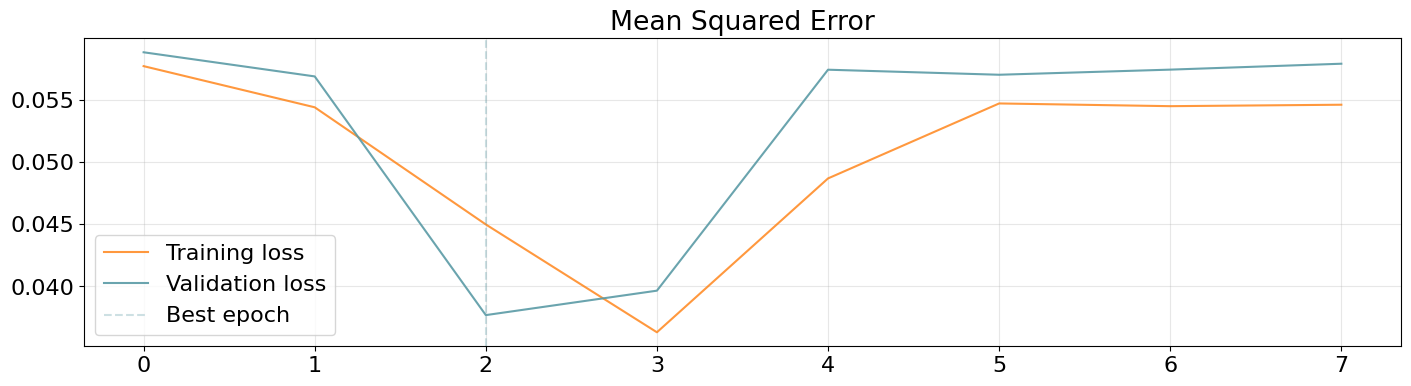

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('LSTM_3_CNN')
model = tfk.models.load_model('LSTM_3_CNN')

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (699, 60)
Mean Squared Error: 0.10918727517127991
Mean Absolute Error: 0.28057661652565


In [ ]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

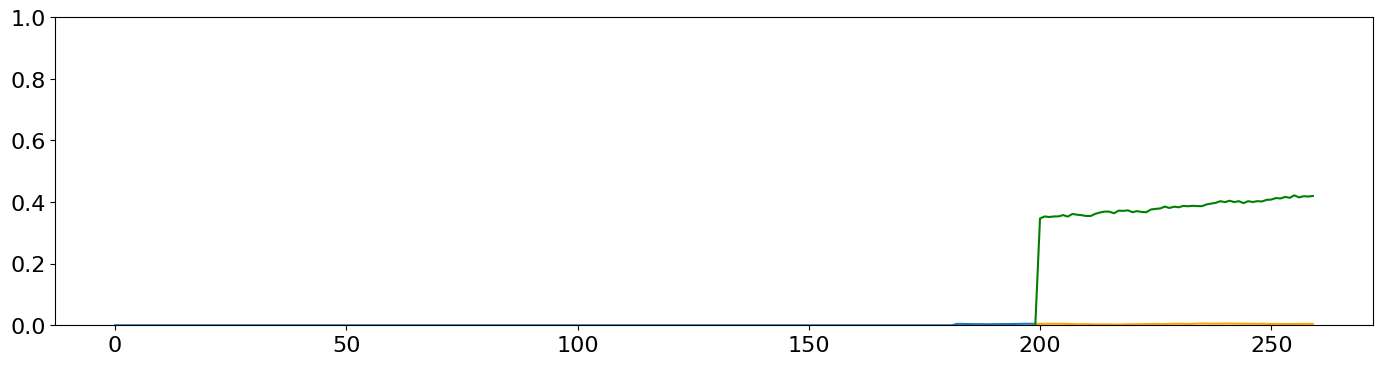

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

0.283326536882518

In [ ]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [ ]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [ ]:
future_predictions = model.predict(future,verbose=1)

1500/1500 [==============================] - 9s 6ms/step


In [ ]:
maes.shape

(60, 1)

In [ ]:
future_predictions.shape

(48000, 60)

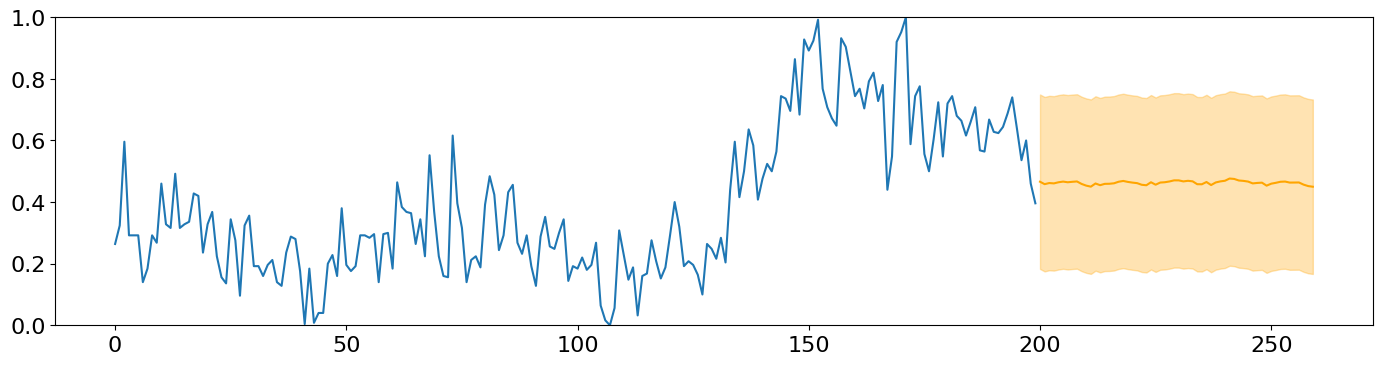

In [ ]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## CNN + LSTM Model

In [ ]:
output_shape

(9, 1)

In [ ]:
def build_CONV_LSTM_model_2(input_shape, output_shape, convolutions):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.BatchNormalization()(input_layer)

    for i in range(convolutions):
        # Add a 1D Convolution layer with 128 filters and a kernel size of 3
        x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv1'+str(i))(x)
        x = tfkl.MaxPooling1D(pool_size=2, strides=None, padding="valid")

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(x)

    for i in range(convolutions):
        # Add a 1D Convolution layer with 128 filters and a kernel size of 3
        x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv2'+str(i))(x)
        x = tfkl.MaxPooling1D(pool_size=2, strides=None, padding="valid")

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[0], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    flattened_input = tfkl.Flatten()(output_layer)

    # Add a Dense layer with 60 neurons
    dense_layer = tfkl.Dense(output_shape[0], activation='relu', name='dense_layer')(flattened_input)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=dense_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
model = build_CONV_LSTM_model_2(input_shape, output_shape, 4)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 conv10 (Conv1D)             (None, 200, 64)           256       
                                                                 
 conv11 (Conv1D)             (None, 200, 64)           12352     
                                                                 
 conv12 (Conv1D)             (None, 200, 64)           12352     
                                                                 
 conv13 (Conv1D)             (None, 200, 64)           12352     
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          66048     
 ctional)                                                        
                                                   

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
1502/1502 [==============================] - 36s 20ms/step - loss: 0.0676 - val_loss: 0.0522 - lr: 0.0010
Epoch 2/200
1502/1502 [==============================] - 30s 20ms/step - loss: 0.0355 - val_loss: 0.0210 - lr: 0.0010
Epoch 3/200
1502/1502 [==============================] - 30s 20ms/step - loss: 0.0129 - val_loss: 0.0216 - lr: 0.0010
Epoch 4/200
1502/1502 [==============================] - 30s 20ms/step - loss: 0.0124 - val_loss: 0.0208 - lr: 0.0010
Epoch 5/200
1502/1502 [==============================] - 30s 20ms/step - loss: 0.0122 - val_loss: 0.0202 - lr: 0.0010
Epoch 6/200
1502/1502 [==============================] - 29s 19ms/step - loss: 0.0121 - val_loss: 0.0202 - lr: 0.0010
Epoch 7/200
1502/1502 [==============================] - 29s 20ms/step - loss: 0.0118 - val_loss: 0.0206 - lr: 0.0010
Epoch 8/200
1502/1502 [==============================] - 30s 20ms/step - loss: 0.0116 - val_loss: 0.0203 - lr: 0.0010
Epoch 9/200
1502/1502 [==============================] -

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('LSTM_CNN')
model = tfk.models.load_model('LSTM_CNN')

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

In [ ]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [ ]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [ ]:
future_predictions = model.predict(future,verbose=1)

In [ ]:
maes.shape

In [ ]:
future_predictions.shape

In [ ]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## CNN + LSTM Model 2

In [ ]:
def build_CONV_LSTM_model_2(input_shape, output_shape, convolutions):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.BatchNormalization()(input_layer)

    for i in range(convolutions):
        # Add 3 parallel convolution layers
        x1 = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv1'+str(i)+str(i))(x)
        x1 = tfkl.MaxPooling1D(pool_size=2, strides=None, padding="valid")(x1)
        x2 = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv1'+str(i)+str(i+1))(x)
        x2 = tfkl.MaxPooling1D(pool_size=2, strides=None, padding="valid")(x2)
        x3 = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv1'+str(i)+str(i+2))(x)
        x3 = tfkl.MaxPooling1D(pool_size=2, strides=None, padding="valid")(x3)
        x = tfkl.concatenate([x1, x2, x3])

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(x)

    for i in range(convolutions):
        # Add 3 parallel convolution layers
        x1 = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv2'+str(i)+str(i))(x)
        x1 = tfkl.MaxPooling1D(pool_size=2, strides=None, padding="valid")(x1)
        x2 = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv2'+str(i)+str(i+1))(x)
        x2 = tfkl.MaxPooling1D(pool_size=2, strides=None, padding="valid")(x2)
        x3 = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv2'+str(i)+str(i+2))(x)
        x3 = tfkl.MaxPooling1D(pool_size=2, strides=None, padding="valid")(x3)
        x = tfkl.concatenate([x1, x2, x3])

    # Add a final Convolution layer to match the desired output shape
    x = tfkl.Conv1D(output_shape[0], 3, padding='same', name='output_layer')(x)
    x = tfkl.GlobalAveragePooling1D(data_format=None, keepdims=False)(x)

    # Add a Dense layer with 60 neurons
    dense_layer = tfkl.Dense(output_shape[0], activation='relu', name='dense_layer')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=dense_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), metrics=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 batch_normalization_2 (Bat  (None, 200, 1)               4         ['input_layer[0][0]']         
 chNormalization)                                                                                 
                                                                                                  
 conv100 (Conv1D)            (None, 200, 64)              256       ['batch_normalization_2[0][0]'
                                                                    ]                             
                                                                                    

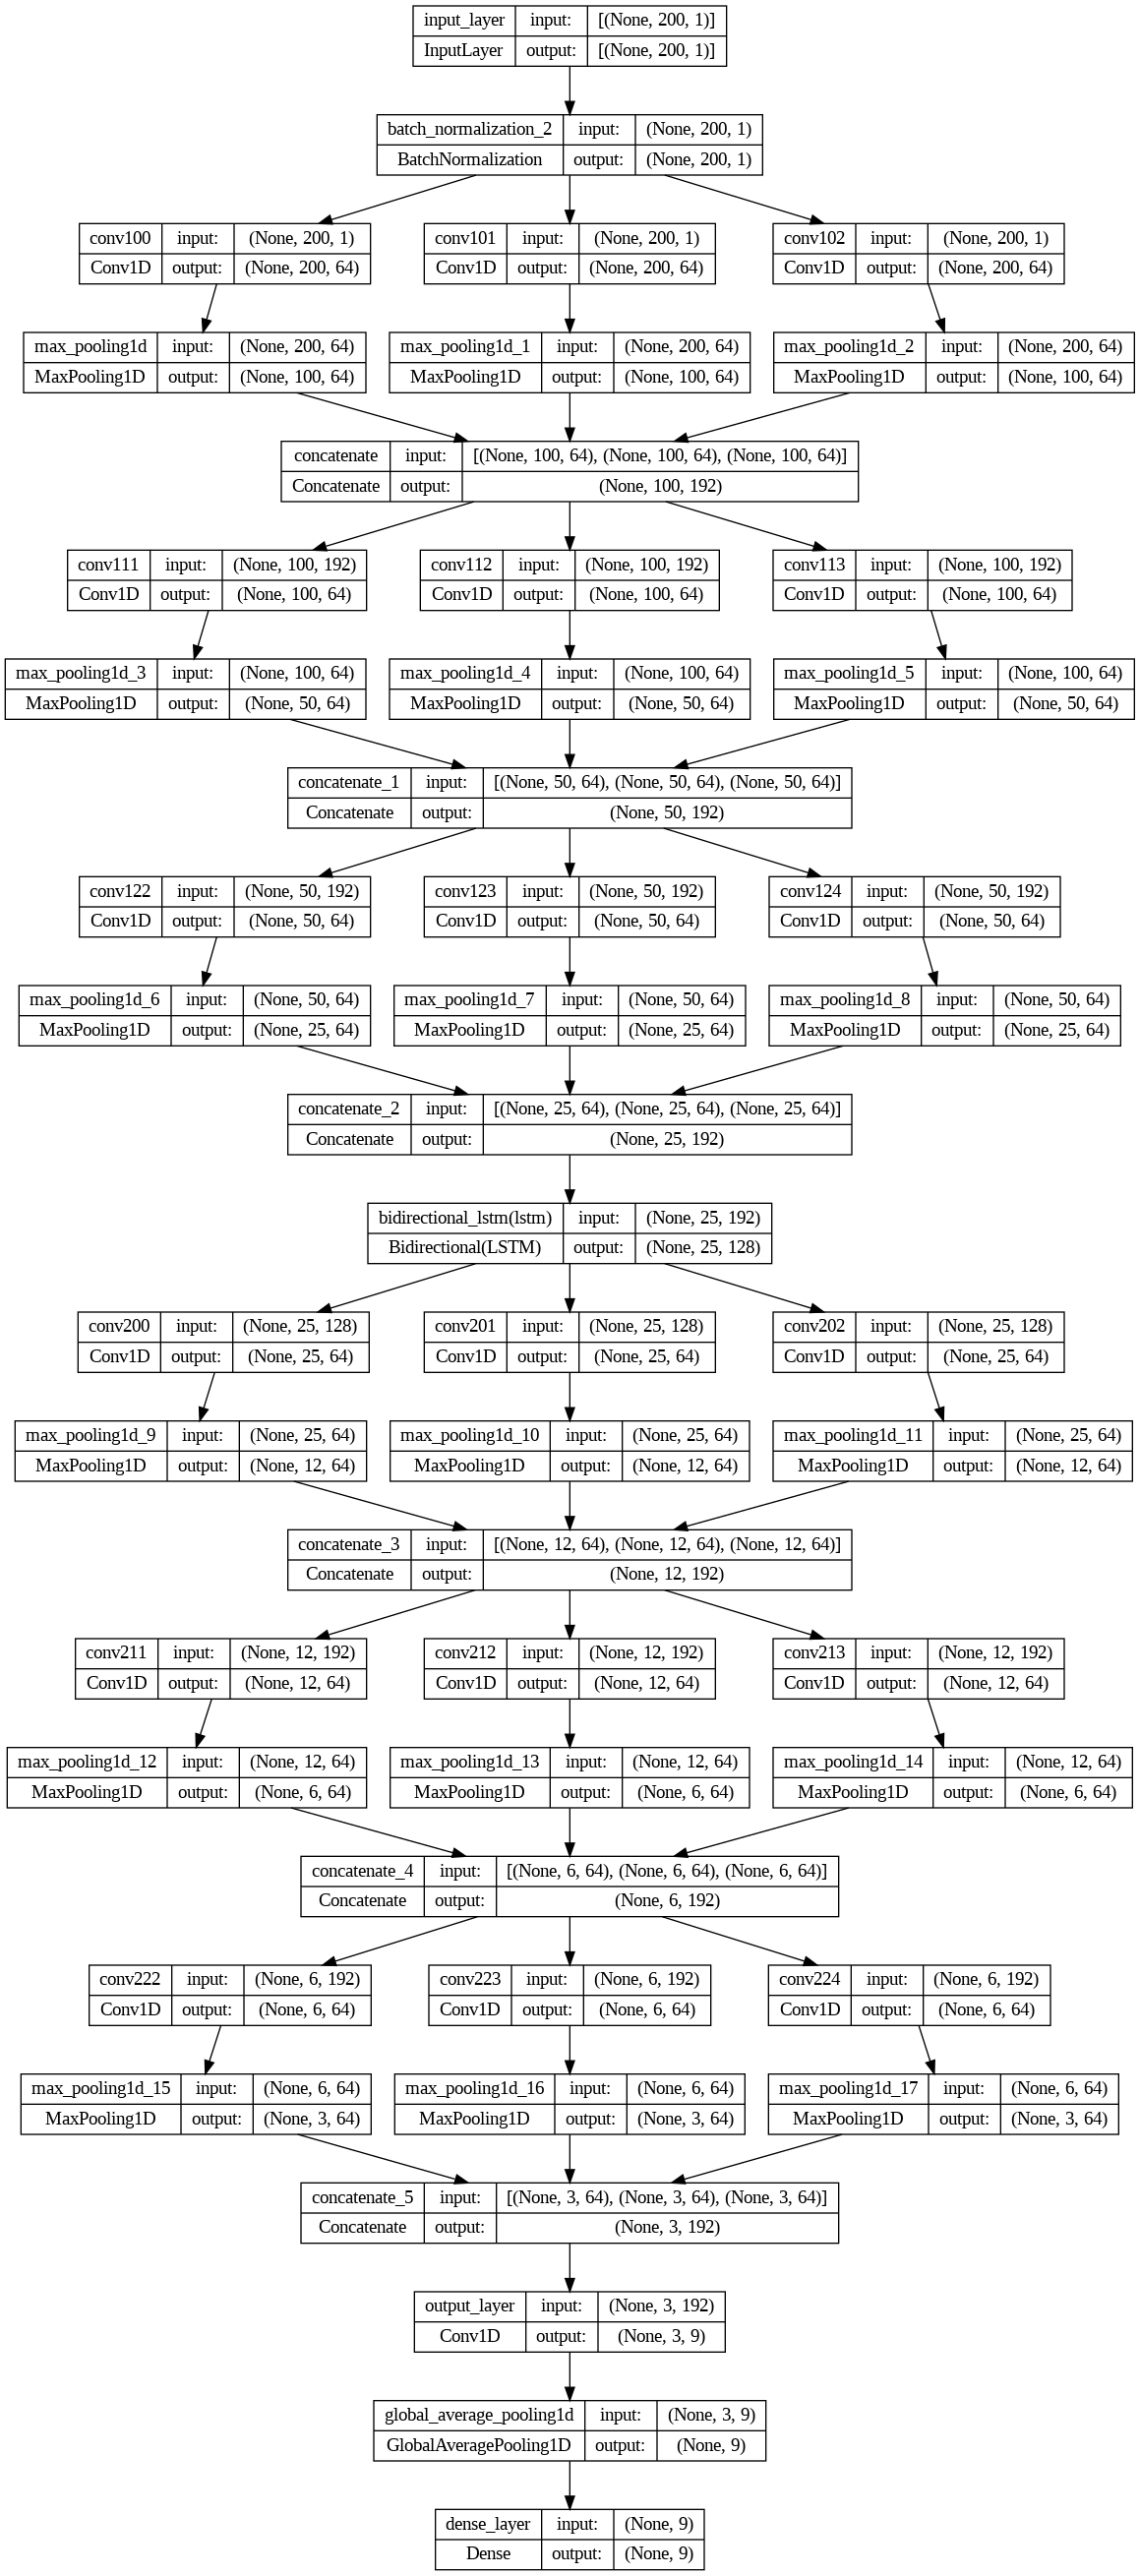

In [ ]:
model = build_CONV_LSTM_model_2(input_shape, output_shape, 3)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
10050/10050 [==============================] - 165s 15ms/step - loss: 0.1061 - mean_squared_error: 0.0218 - val_loss: 0.1644 - val_mean_squared_error: 0.0462 - lr: 0.0010
Epoch 2/200
10050/10050 [==============================] - 152s 15ms/step - loss: 0.0664 - mean_squared_error: 0.0096 - val_loss: 0.1674 - val_mean_squared_error: 0.0476 - lr: 0.0010
Epoch 3/200
10050/10050 [==============================] - 150s 15ms/step - loss: 0.0552 - mean_squared_error: 0.0070 - val_loss: 0.1673 - val_mean_squared_error: 0.0479 - lr: 0.0010
Epoch 4/200
10050/10050 [==============================] - 150s 15ms/step - loss: 0.0495 - mean_squared_error: 0.0058 - val_loss: 0.1665 - val_mean_squared_error: 0.0474 - lr: 0.0010
Epoch 5/200
10050/10050 [==============================] - 150s 15ms/step - loss: 0.0459 - mean_squared_error: 0.0051 - val_loss: 0.1673 - val_mean_squared_error: 0.0478 - lr: 0.0010
Epoch 6/200
 5519/10050 [===============>..............] - ETA: 1:05 - loss: 0.0439 -

KeyboardInterrupt: ignored

In [ ]:
model.save('LSTM_CNN')
#model = tfk.models.load_model('LSTM_CNN')

In [ ]:
model = tf.keras.models.load_model('LSTM_CNN')

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (135872, 9)
Mean Squared Error: 0.04652012139558792
Mean Absolute Error: 0.16485773026943207


In [ ]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

NameError: ignored

In [ ]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [ ]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [ ]:
future_predictions = model.predict(future,verbose=1)

In [ ]:
maes.shape

In [ ]:
future_predictions.shape

In [ ]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## Transformer

In [40]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = tfkl.LayerNormalization(epsilon=epsilon)(inputs)
  x = tfkl.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = tfkl.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = tfkl.LayerNormalization(epsilon=epsilon)(res)
  x = tfkl.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = tfkl.Dropout(dropout)(x)
  x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 200, 1, 9
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = tfkl.Dense(dim, activation="relu")(x)
    x = tfkl.Dropout(mlp_dropout)(x)

  outputs = tfkl.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

In [41]:
y_train.shape

(106796, 9)

In [42]:
y_train[0]

array([0.19907407, 0.18240741, 0.1537037 , 0.15740741, 0.19444444,
       0.26111111, 0.28425926, 0.28611111, 0.25740741])

In [43]:
model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
model.compile(loss='mae', metrics=['mse'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 200, 1)               2         ['input_2[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 200, 1)               3585      ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                            

In [44]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs= 43,
    batch_size=64,
    #callbacks=callbacks,
)

Epoch 1/43
1335/1335 [==============================] - 113s 75ms/step - loss: 0.0765 - mse: 0.0136 - val_loss: 0.0807 - val_mse: 0.0155
Epoch 2/43
1335/1335 [==============================] - 102s 77ms/step - loss: 0.0656 - mse: 0.0101 - val_loss: 0.0723 - val_mse: 0.0142
Epoch 3/43
1335/1335 [==============================] - 104s 78ms/step - loss: 0.0638 - mse: 0.0097 - val_loss: 0.0776 - val_mse: 0.0151
Epoch 4/43
1335/1335 [==============================] - 105s 78ms/step - loss: 0.0631 - mse: 0.0095 - val_loss: 0.0716 - val_mse: 0.0141
Epoch 5/43
1335/1335 [==============================] - 105s 78ms/step - loss: 0.0619 - mse: 0.0093 - val_loss: 0.0745 - val_mse: 0.0144
Epoch 6/43
1335/1335 [==============================] - 105s 79ms/step - loss: 0.0615 - mse: 0.0092 - val_loss: 0.0717 - val_mse: 0.0141
Epoch 7/43
1335/1335 [==============================] - 105s 79ms/step - loss: 0.0610 - mse: 0.0090 - val_loss: 0.0711 - val_mse: 0.0140
Epoch 8/43
1335/1335 [===================

In [45]:
model.save('transformer_forecasting')

In [46]:
model = tf.keras.models.load_model('transformer_forecasting')

In [47]:
model.save('transformer_forecasting_tensorflow', save_format='tf', include_optimizer=True)

In [48]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (48159, 9)
Mean Squared Error: 0.02313631772994995
Mean Absolute Error: 0.10355452448129654


In [49]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

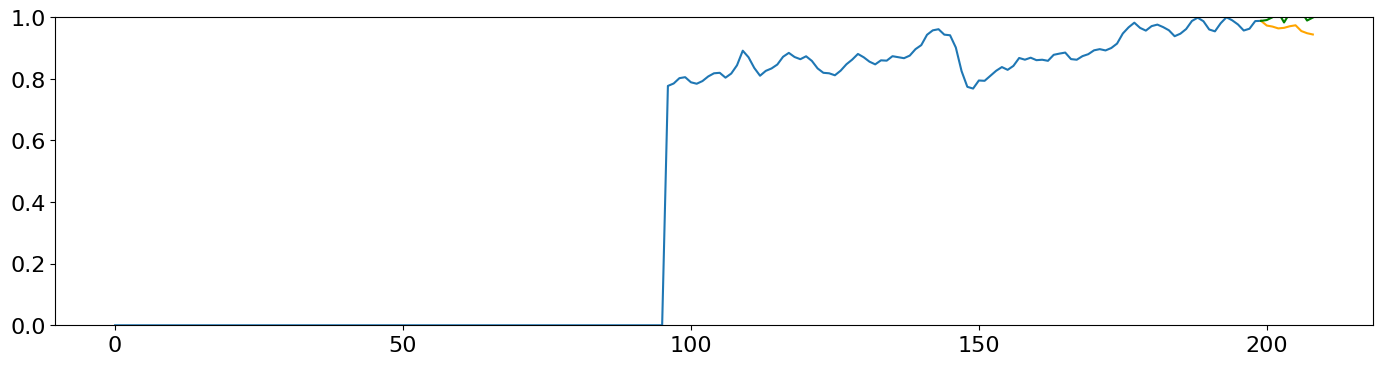

In [50]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [51]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [52]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

0.06516109718886788

In [53]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [54]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [55]:
future_predictions = model.predict(future,verbose=1)

1500/1500 [==============================] - 19s 13ms/step


In [56]:
maes.shape

(9, 1)

In [57]:
future_predictions.shape

(48000, 9)

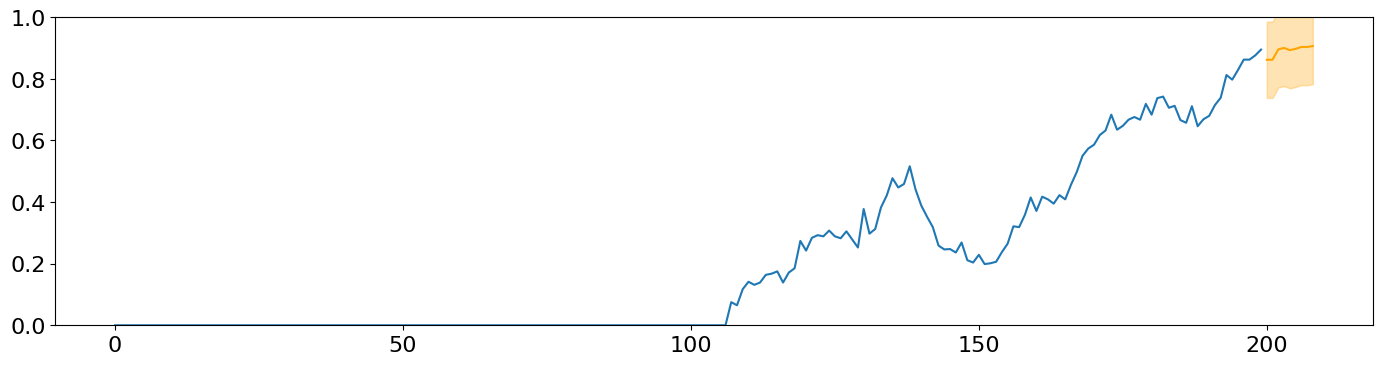

In [58]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## Transformer 2

In [59]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = tfkl.LayerNormalization(epsilon=epsilon)(inputs)
  x = tfkl.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = tfkl.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = tfkl.LayerNormalization(epsilon=epsilon)(res)
  x = tfkl.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = tfkl.Dropout(dropout)(x)
  x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 200, 1, 9
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = tfkl.Dense(dim, activation="relu")(x)
    x = tfkl.Dropout(mlp_dropout)(x)

  outputs = tfkl.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

In [60]:
y_train.shape

(106796, 9)

In [61]:
y_train[0]

array([0.19907407, 0.18240741, 0.1537037 , 0.15740741, 0.19444444,
       0.26111111, 0.28425926, 0.28611111, 0.25740741])

In [62]:
model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=6, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
model.compile(loss='mae', metrics=['mse'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 layer_normalization_8 (Lay  (None, 200, 1)               2         ['input_3[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_4 (Mu  (None, 200, 1)               3585      ['layer_normalization_8[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_8[0][0]
                                                                    ']                      

In [63]:
tfk.utils.plot_model(model)

In [64]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs= 150,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/150
1335/1335 [==============================] - 163s 112ms/step - loss: 0.0761 - mse: 0.0133 - val_loss: 0.0747 - val_mse: 0.0146
Epoch 2/150
1335/1335 [==============================] - 154s 115ms/step - loss: 0.0657 - mse: 0.0101 - val_loss: 0.0740 - val_mse: 0.0145
Epoch 3/150
1335/1335 [==============================] - 155s 116ms/step - loss: 0.0639 - mse: 0.0097 - val_loss: 0.0799 - val_mse: 0.0153
Epoch 4/150
1335/1335 [==============================] - 155s 116ms/step - loss: 0.0632 - mse: 0.0095 - val_loss: 0.0715 - val_mse: 0.0140
Epoch 5/150
1335/1335 [==============================] - 155s 116ms/step - loss: 0.0623 - mse: 0.0093 - val_loss: 0.0740 - val_mse: 0.0143
Epoch 6/150
1335/1335 [==============================] - 155s 116ms/step - loss: 0.0616 - mse: 0.0092 - val_loss: 0.0722 - val_mse: 0.0142
Epoch 7/150
1335/1335 [==============================] - 156s 117ms/step - loss: 0.0611 - mse: 0.0091 - val_loss: 0.0712 - val_mse: 0.0140
Epoch 8/150
1335/1335 [====

In [65]:
model.save('transformer_deeper_forecasting')

In [66]:
model = tf.keras.models.load_model('transformer_deeper_forecasting')

In [67]:
model.save('transformer_deeper_forecasting_tensorflow', save_format='tf', include_optimizer=True)

In [68]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (48159, 9)
Mean Squared Error: 0.023121831938624382
Mean Absolute Error: 0.10464885085821152


In [69]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

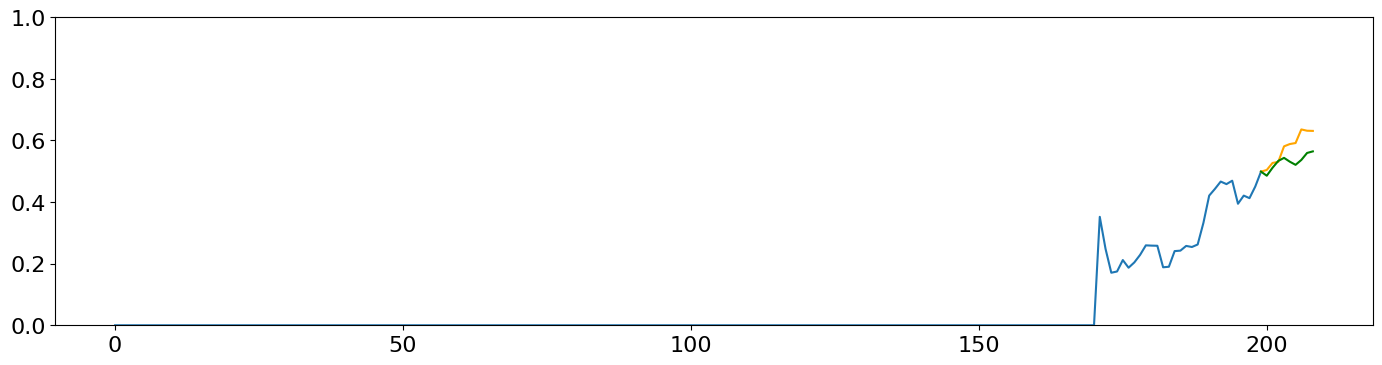

In [70]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [71]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [72]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

0.06408058861911894

In [73]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [74]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [75]:
future_predictions = model.predict(future,verbose=1)

1500/1500 [==============================] - 28s 19ms/step


In [76]:
maes.shape

(9, 1)

In [77]:
future_predictions.shape

(48000, 9)

In [78]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## ResNet 1D

In [ ]:
# Define a residual convolutional block with optional batch normalization
def conv_residual_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling1D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv1D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv1D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
# Define a function to build a VGG18-like model with residual blocks
def build_model_residual(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    mask = tfkl.Masking(mask_value=0.0)(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv1D(filters=64, kernel_size=3, padding='same', name='Conv0')(mask)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create residual blocks
    x1 = conv_residual_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_residual_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_residual_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_residual_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_residual_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_residual_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_residual_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_residual_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling1D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape[0], name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_Residual')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    #optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    #loss = tfk.losses.CategoricalCrossentropy()
    #metrics = ['accuracy']

    # Compile the model
    #model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), metrics=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
    return model

Model: "VGG18_Residual"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 masking_1 (Masking)         (None, 200, 1)               0         ['Input_Layer[0][0]']         
                                                                                                  
 Conv0 (Conv1D)              (None, 200, 64)              256       ['masking_1[0][0]']           
                                                                                                  
 BatchNorm0 (BatchNormaliza  (None, 200, 64)              256       ['Conv0[0][0]']               
 tion)                                                                               

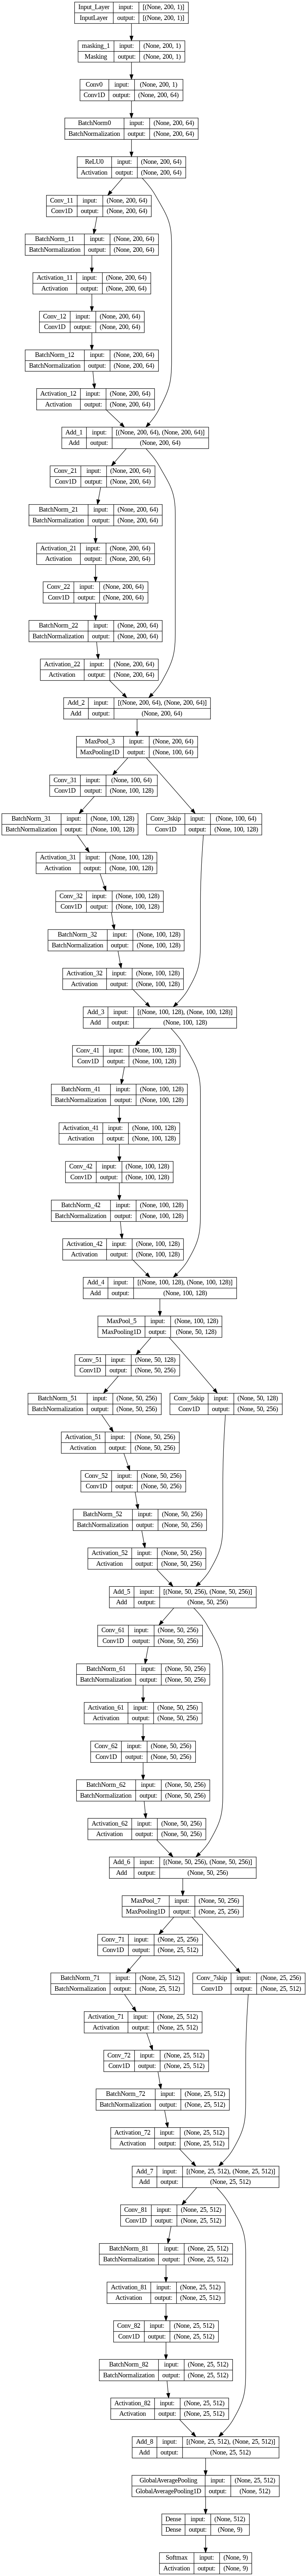

In [ ]:
residual_model = build_model_residual()
residual_model.summary()
tfk.utils.plot_model(residual_model, expand_nested=True, show_shapes=True)

In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
]

In [ ]:
residual_history = residual_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/200
1335/1335 [==============================] - 54s 30ms/step - loss: 0.3050 - mean_squared_error: 0.1475 - val_loss: 0.3187 - val_mean_squared_error: 0.1609 - lr: 0.0010
Epoch 2/200
1335/1335 [==============================] - 40s 30ms/step - loss: 0.2990 - mean_squared_error: 0.1437 - val_loss: 0.3184 - val_mean_squared_error: 0.1597 - lr: 0.0010
Epoch 3/200
1335/1335 [==============================] - 40s 30ms/step - loss: 0.2987 - mean_squared_error: 0.1435 - val_loss: 0.3190 - val_mean_squared_error: 0.1638 - lr: 0.0010
Epoch 4/200
1335/1335 [==============================] - 41s 31ms/step - loss: 0.2985 - mean_squared_error: 0.1439 - val_loss: 0.3193 - val_mean_squared_error: 0.1621 - lr: 0.0010
Epoch 5/200
1335/1335 [==============================] - 44s 33ms/step - loss: 0.2985 - mean_squared_error: 0.1435 - val_loss: 0.3186 - val_mean_squared_error: 0.1643 - lr: 0.0010
Epoch 6/200
1335/1335 [==============================] - 40s 30ms/step - loss: 0.2984 - mean_squared

KeyboardInterrupt: ignored

In [ ]:
# Plot validation loss for different models
plt.figure(figsize=(15, 3))
#plt.plot(baseline_history['val_loss'], label='VGG18', alpha=0.8, color='#ff7f0e')
#plt.plot(bn_history['val_loss'], label='VGG18+BN', alpha=0.8, color='#1B87B5')
plt.plot(residual_history['val_loss'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot validation accuracy for different models
plt.figure(figsize=(15, 3))
#plt.plot(baseline_history['val_accuracy'], label='VGG18', alpha=0.8, color='#ff7f0e')
#plt.plot(bn_history['val_accuracy'], label='VGG18+BN', alpha=0.8, color='#1B87B5')
plt.plot(residual_history['val_accuracy'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Show the plots
plt.show()

In [ ]:
residual_model.save('residual_model_masking_classifier')
del residual_model

In [ ]:
model = tfk.models.load_model('residual_model_masking_classifier')

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (48159, 9)
Mean Squared Error: 0.023656338453292847
Mean Absolute Error: 0.10698242485523224


In [ ]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

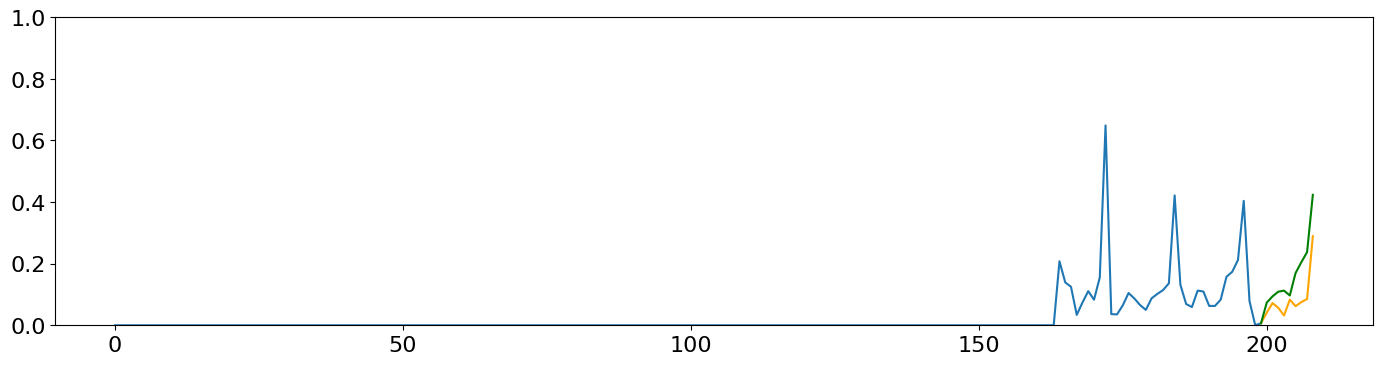

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

In [ ]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [ ]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [ ]:
future_predictions = model.predict(future,verbose=1)

In [ ]:
maes.shape

In [ ]:
future_predictions.shape

In [ ]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## CNN + LSTM + Attention

In [ ]:
output_shape

(9, 1)

In [ ]:
def build_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    '''
    x = tfkl.Conv1D(32, 3, padding='same', activation='relu')(input_layer)
    x = tfkl.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu')(x)
    cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu')(x)

    attention_cnn = tfkl.Attention()([cnn, cnn])
    combined_cnn = tfkl.Concatenate(axis=-1)([cnn, attention_cnn])
    '''

    # Add LSTM
    lstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    flatten1 = tfkl.Flatten()(lstm)

    # Attention layer
    num_heads = 4
    key_dim = 32 # embedding dimension
    attention = tfkl.MultiHeadAttention(num_heads, key_dim, value_dim=None, dropout=0.0, use_bias=True, kernel_initializer="glorot_uniform", bias_initializer="zeros")(input_layer, input_layer)
    flatten2 = tfkl.Flatten()(attention)

    batch = tfkl.BatchNormalization()(input_layer)
    x = tfkl.Conv1D(32, 3, padding='same', activation='relu')(batch)
    x = tfkl.MaxPooling1D(pool_size=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = tfkl.MaxPooling1D(pool_size=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = tfkl.MaxPooling1D(pool_size=2)(x)
    x = tfkl.BatchNormalization()(x)
    cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = tfkl.MaxPooling1D(pool_size=2)(x)
    x = tfkl.BatchNormalization()(x)
    flatten3 = tfkl.Flatten()(x)
    # Concatenate LSTM output and attention output
    combined = tfkl.Concatenate(axis=-1)([flatten1, flatten2, flatten3])

    flattened_input = tfkl.Flatten()(combined)

    # Fully connected layer for prediction
    outputs = tfkl.Dense(9)(flattened_input)

    model = tf.keras.Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 batch_normalization_8 (Bat  (None, 200, 1)               4         ['input_layer[0][0]']         
 chNormalization)                                                                                 
                                                                                                  
 conv1d_16 (Conv1D)          (None, 200, 32)              128       ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                           

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
1502/1502 [==============================] - 39s 21ms/step - loss: 0.0187 - val_loss: 0.0247 - lr: 0.0010
Epoch 2/200
1502/1502 [==============================] - 31s 21ms/step - loss: 0.0119 - val_loss: 0.0212 - lr: 0.0010
Epoch 3/200
1502/1502 [==============================] - 31s 21ms/step - loss: 0.0101 - val_loss: 0.0200 - lr: 0.0010
Epoch 4/200
1502/1502 [==============================] - 31s 21ms/step - loss: 0.0092 - val_loss: 0.0200 - lr: 0.0010
Epoch 5/200
1502/1502 [==============================] - 31s 21ms/step - loss: 0.0088 - val_loss: 0.0194 - lr: 0.0010
Epoch 6/200
1502/1502 [==============================] - 31s 21ms/step - loss: 0.0086 - val_loss: 0.0204 - lr: 0.0010
Epoch 7/200
1502/1502 [==============================] - 31s 21ms/step - loss: 0.0084 - val_loss: 0.0197 - lr: 0.0010
Epoch 8/200
1502/1502 [==============================] - 31s 21ms/step - loss: 0.0082 - val_loss: 0.0194 - lr: 0.0010
Epoch 9/200
1502/1502 [==============================] -

In [ ]:
model.save('LSTM_CNN_Attention')
model = tfk.models.load_model('LSTM_CNN_Attention')

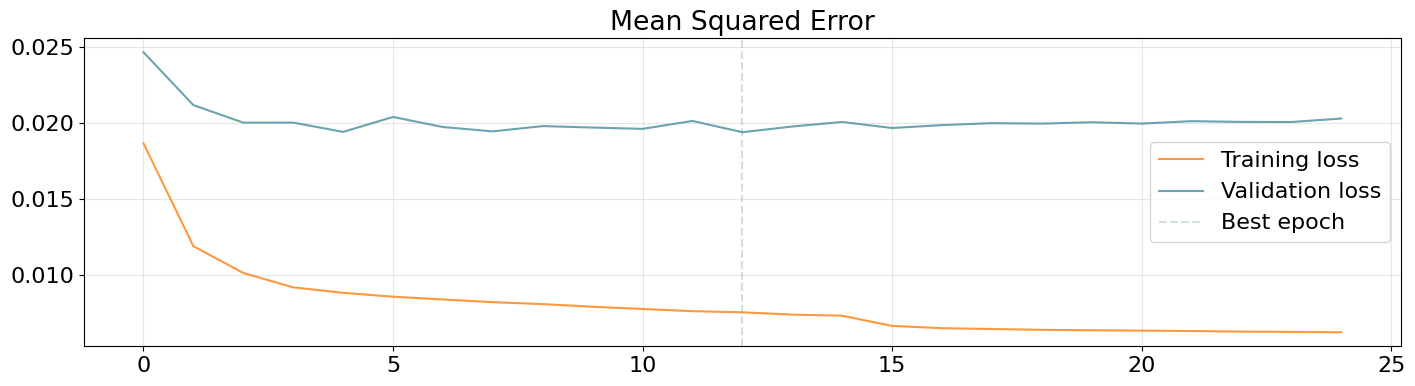

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (48159, 9)
Mean Squared Error: 0.021679231896996498
Mean Absolute Error: 0.10223010182380676


In [ ]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

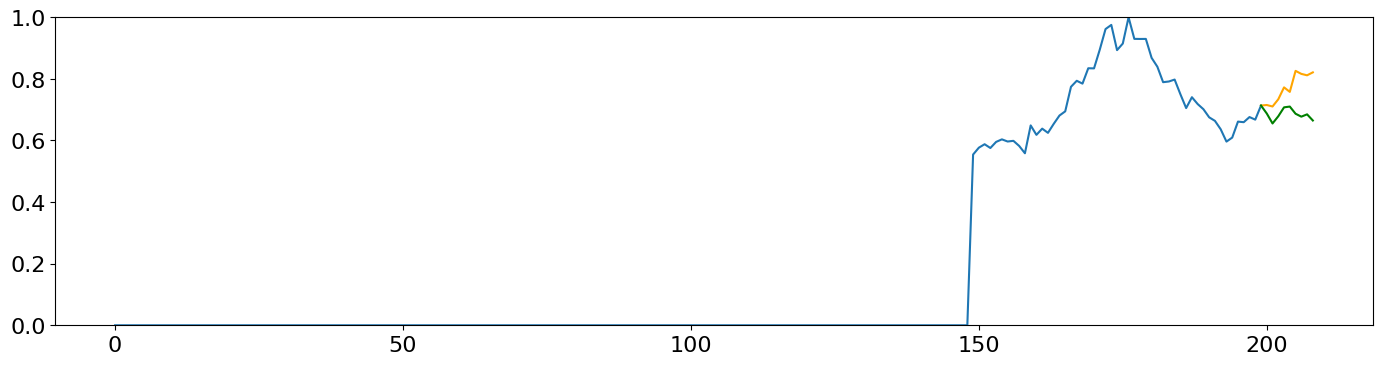

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

0.06583287313515206

In [ ]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [ ]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [ ]:
future_predictions = model.predict(future,verbose=1)

1500/1500 [==============================] - 10s 7ms/step


In [ ]:
maes.shape

(9, 1)

In [ ]:
future_predictions.shape

(48000, 9)

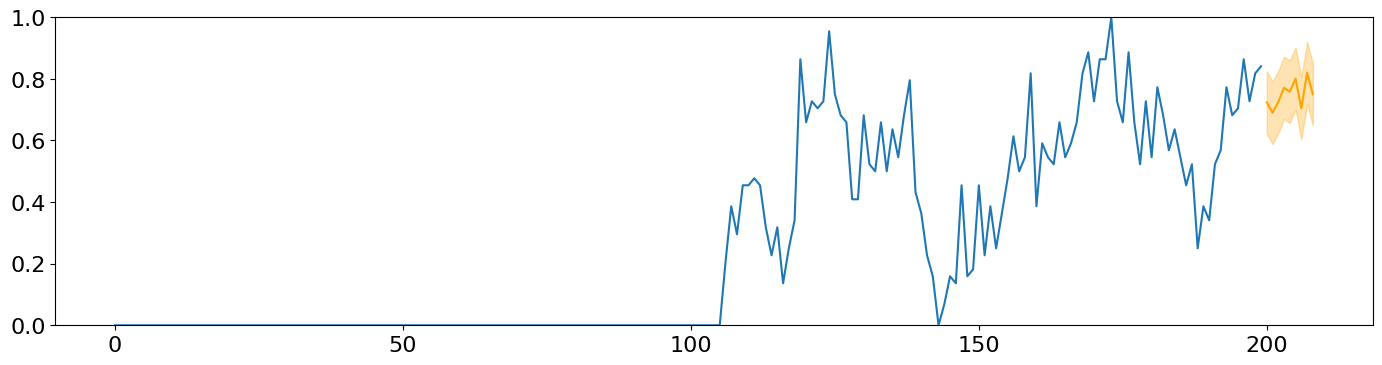

In [ ]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## CNN + LSTM + Attention + Skip

In [ ]:
output_shape

(9, 1)

In [ ]:
def build_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Masking(mask_value=0.0, name='masking')(input_layer)

    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv_1')(x)
    x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv_2')(x)
    x_conv = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv_3')(x)
    x_conv_2 = tfkl.Conv1D(32, 3, padding='same', activation='relu', name='conv_4')(x_conv)

    # MULTIHAED ATTENTION
    # Add a Bidirectional LSTM layer with 64 units
    output_LSTM_1 = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='lstm_1'), name='bidirectional_lstm_1')(x) # 200,64
    skip_connection_1 = tfkl.Add()([output_LSTM_1, x_conv])  # 200,64 + 200,64 = 200,64
    #conv_skip_connection_1 = tfkl.Conv1D(32, 3, padding='same', activation='relu', name='conv_21')(skip_connection_1) # 200,32
    output_LSTM_2 = tfkl.Bidirectional(tfkl.LSTM(16, return_sequences=True, name='lstm_2'), name='bidirectional_lstm_2')(skip_connection_1) # 200,32
    skip_connection_2 = tfkl.Add()([output_LSTM_2, x_conv_2])  # 200,32 + 200,32 = 200,32
    output_LSTM_3 = tfkl.Bidirectional(tfkl.LSTM(8, return_sequences=True, name='lstm_3'), name='bidirectional_lstm_3')(skip_connection_2)


    # Adding MultiHead Attention Layer
    num_heads = 8
    key_dim = 64

    x = tf.keras.layers.MultiHeadAttention(
        num_heads,
        key_dim,
        dropout=0.30,
        )(output_LSTM_3, output_LSTM_3)

     # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm_1'), name='bidirectional_lstm_121')(x)
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm_2'), name='bidirectional_lstm_122')(x)
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm_3'), name='bidirectional_lstm_123')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[0], 3, padding='same', name='output_layer')(x)

    print(output_layer.shape[1], output_shape[0])
    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    flattened_input = tfkl.Flatten()(output_layer)

    # Add a Dense layer with 60 neurons
    dense_layer = tfkl.Dense(9, activation='linear', name='dense_layer')(flattened_input)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=dense_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

200 9
Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 200, 1)]             0         []                            
                                                                                                  
 masking (Masking)           (None, 200, 1)               0         ['input_layer[0][0]']         
                                                                                                  
 conv_1 (Conv1D)             (None, 200, 128)             512       ['masking[0][0]']             
                                                                                                  
 conv_2 (Conv1D)             (None, 200, 64)              24640     ['conv_1[0][0]']              
                                                                              

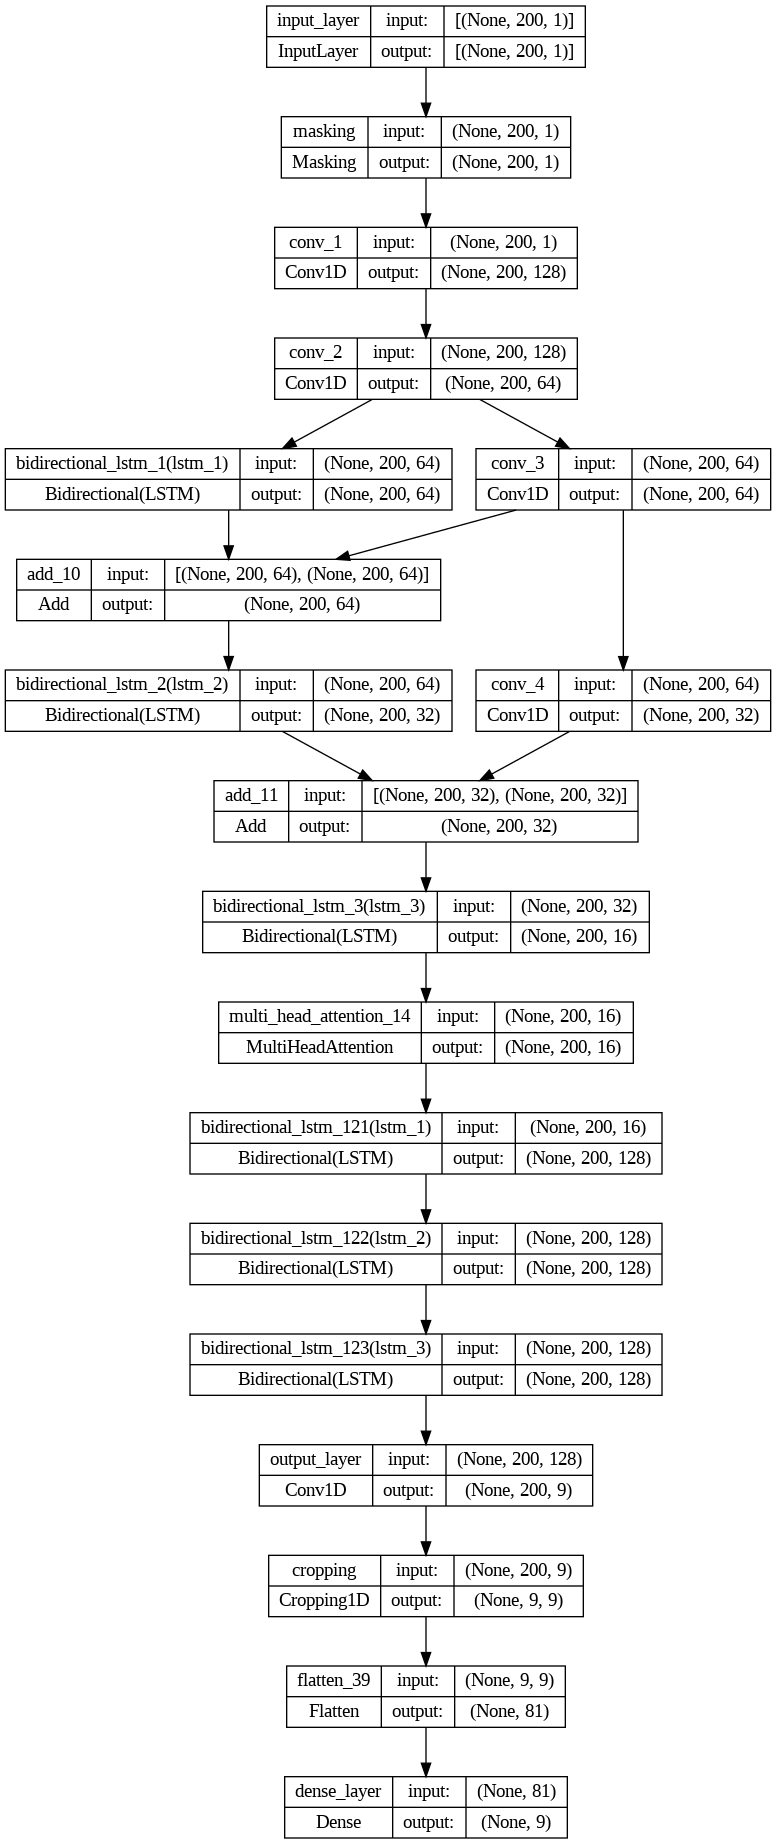

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
1502/1502 [==============================] - 155s 90ms/step - loss: 0.0177 - val_loss: 0.0206 - lr: 0.0010
Epoch 2/200
1502/1502 [==============================] - 131s 87ms/step - loss: 0.0122 - val_loss: 0.0200 - lr: 0.0010
Epoch 3/200
1502/1502 [==============================] - 131s 87ms/step - loss: 0.0116 - val_loss: 0.0207 - lr: 0.0010
Epoch 4/200
1502/1502 [==============================] - 131s 87ms/step - loss: 0.0105 - val_loss: 0.0196 - lr: 0.0010
Epoch 5/200
1502/1502 [==============================] - 130s 87ms/step - loss: 0.0098 - val_loss: 0.0186 - lr: 0.0010
Epoch 6/200
1502/1502 [==============================] - 130s 87ms/step - loss: 0.0094 - val_loss: 0.0189 - lr: 0.0010
Epoch 7/200
1502/1502 [==============================] - 130s 86ms/step - loss: 0.0091 - val_loss: 0.0194 - lr: 0.0010
Epoch 8/200
1502/1502 [==============================] - 130s 87ms/step - loss: 0.0089 - val_loss: 0.0179 - lr: 0.0010
Epoch 9/200
1502/1502 [=========================

In [ ]:
model.save('LSTM_CNN_Attention')
model = tfk.models.load_model('LSTM_CNN_Attention')

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Test evaluation

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

In [ ]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [ ]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [ ]:
future_predictions = model.predict(future,verbose=1)

In [ ]:
maes.shape

In [ ]:
future_predictions.shape

In [ ]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## Autoregressive Forecasting

In [65]:
model = tfk.models.load_model('transformer_forecasting')

In [66]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (48159, 9)
Mean Squared Error: 0.02313631772994995
Mean Absolute Error: 0.10355452448129654


In [67]:
X_test.shape

(48159, 200)

In [68]:
new = np.concatenate([X_test, predictions], axis=1)
new.shape

(48159, 209)

In [69]:
x_new = new[:,-200:]

In [70]:
# Predict the test set using the model
predictions2 = model.predict(x_new, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions2.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions2.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions2.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (48159, 9)
Mean Squared Error: 0.030063150450587273
Mean Absolute Error: 0.12701353430747986


In [72]:
final_pred = np.concatenate([predictions, predictions2], axis=1)
final_pred.shape

(48159, 18)

In [ ]:
## final block of code to be put in model.py
predictions = model.predict(X_test, verbose=0)
X_test_new = np.concatenate([X_test, predictions], axis=1)[:,-200:]
predictions2 = model.predict(X_test_new, verbose=0)
final_pred = np.concatenate([predictions, predictions2], axis=1)

## Time 2 Vec

In [114]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer


class Time2Vec(Layer):
    def __init__(self, kernel_size, periodic_activation='sin'):
        '''

        :param kernel_size:         The length of time vector representation.
        :param periodic_activation: The periodic activation, sine or cosine, or any future function.
        '''
        super(Time2Vec, self).__init__(
            trainable=True,
            name='Time2VecLayer_'+periodic_activation.upper()
        )

        self.k = kernel_size
        self.p_activation = periodic_activation

    def build(self, input_shape):
        # While i = 0
        self.wb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )

        self.bb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )

        # Else needs to pass the periodic activation
        self.wa = self.add_weight(
            shape=(1, self.k),
            initializer='uniform',
            trainable=True
        )

        self.ba = self.add_weight(
            shape=(1, self.k),
            initializer='uniform',
            trainable=True
        )

        super(Time2Vec, self).build(input_shape)

    def call(self, inputs, **kwargs):
        '''

        :param inputs: A Tensor with shape (batch_size, feature_size, 1)
        :param kwargs:
        :return: A Tensor with shape (batch_size, feature_size, length of time vector representation + 1)
        '''
        bias = self.wb * inputs + self.bb
        if self.p_activation.startswith('sin') :
            wgts = K.sin(K.dot(inputs, self.wa) + self.ba)
        elif self.p_activation.startswith('cos') :
            wgts = K.cos(K.dot(inputs, self.wa) + self.ba)
        else:
            raise NotImplementedError('Neither sine or cosine periodic activation be selected.')
        return K.concatenate([bias, wgts], -1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.k + 1)

In [115]:
# import os
#
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow.keras import layers, Model, backend as K
#from Time2Vec.layers import Time2Vec


def time2vec_lstm(dim, t2v_dim):
    '''

    :param dim:
    :param t2v_dim:
    :return:
    '''
    term = layers.Input(shape=(dim, 1))
    time = layers.Input(shape=(dim, 1))
    xti = Time2Vec(t2v_dim)(time)
    xte = layers.LSTM(32)(term)
    x = layers.Dense(9)(layers.concatenate([xte, layers.Flatten()(xti)]))
    m = Model([time, term], x)
    return m


def general_lstm(dim):
    inp = layers.Input(shape=(dim, 1))
    x = layers.LSTM(32)(inp)
    x = layers.Dense(9)(x)
    m = Model(inp, x)
    return m

In [116]:
model = time2vec_lstm(200, 32)
model.compile(loss='mae', metrics=['mse'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 Time2VecLayer_SIN (Time2Ve  (None, 200, 33)              66        ['input_11[0][0]']            
 c)                                                                                               
                                                                                                  
 lstm_4 (LSTM)               (None, 32)                   4352      ['input_10[0][0]']      

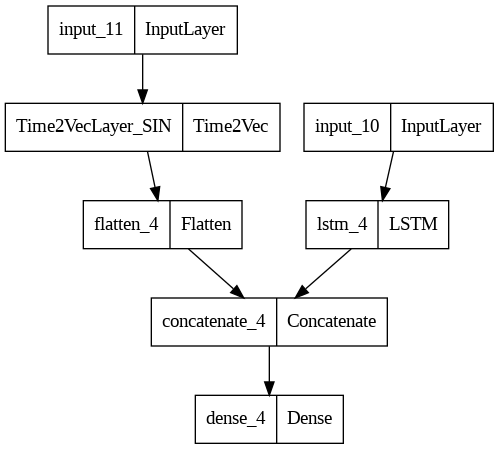

In [117]:
tfk.utils.plot_model(model)

In [118]:
history = model.fit(
    x=[X_train, X_train],
    y=y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=2,
    validation_split=0.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/10
1335/1335 - 15s - loss: 0.0711 - mse: 0.0125 - val_loss: 0.0741 - val_mse: 0.0144 - lr: 0.0010 - 15s/epoch - 11ms/step
Epoch 2/10
1335/1335 - 12s - loss: 0.0623 - mse: 0.0098 - val_loss: 0.0732 - val_mse: 0.0146 - lr: 0.0010 - 12s/epoch - 9ms/step
Epoch 3/10
1335/1335 - 12s - loss: 0.0614 - mse: 0.0096 - val_loss: 0.0738 - val_mse: 0.0147 - lr: 0.0010 - 12s/epoch - 9ms/step
Epoch 4/10
1335/1335 - 12s - loss: 0.0607 - mse: 0.0094 - val_loss: 0.0722 - val_mse: 0.0145 - lr: 0.0010 - 12s/epoch - 9ms/step
Epoch 5/10
1335/1335 - 12s - loss: 0.0601 - mse: 0.0093 - val_loss: 0.0720 - val_mse: 0.0144 - lr: 0.0010 - 12s/epoch - 9ms/step
Epoch 6/10
1335/1335 - 12s - loss: 0.0597 - mse: 0.0092 - val_loss: 0.0718 - val_mse: 0.0143 - lr: 0.0010 - 12s/epoch - 9ms/step
Epoch 7/10
1335/1335 - 12s - loss: 0.0595 - mse: 0.0092 - val_loss: 0.0721 - val_mse: 0.0146 - lr: 0.0010 - 12s/epoch - 9ms/step
Epoch 8/10
1335/1335 - 12s - loss: 0.0592 - mse: 0.0091 - val_loss: 0.0714 - val_mse: 0.0144 - l

In [119]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [121]:
model.save('time2vec_1')
model = tfk.models.load_model('time2vec_1')

AttributeError: ignored

Test evaluation

In [122]:
y_test.shape

(48159, 9)

In [123]:
# Predict the test set using the model
predictions = model.predict([X_test, X_test], verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (48159, 9)
Mean Squared Error: 0.022304872050881386
Mean Absolute Error: 0.10195726901292801


In [124]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

In [131]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [132]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [133]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

0.060472130130408835

In [134]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [135]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [140]:
future_predictions = model.predict([future,future],verbose=1)

1500/1500 [==============================] - 6s 4ms/step


In [141]:
maes.shape

(9, 1)

In [142]:
future_predictions.shape

(48000, 9)

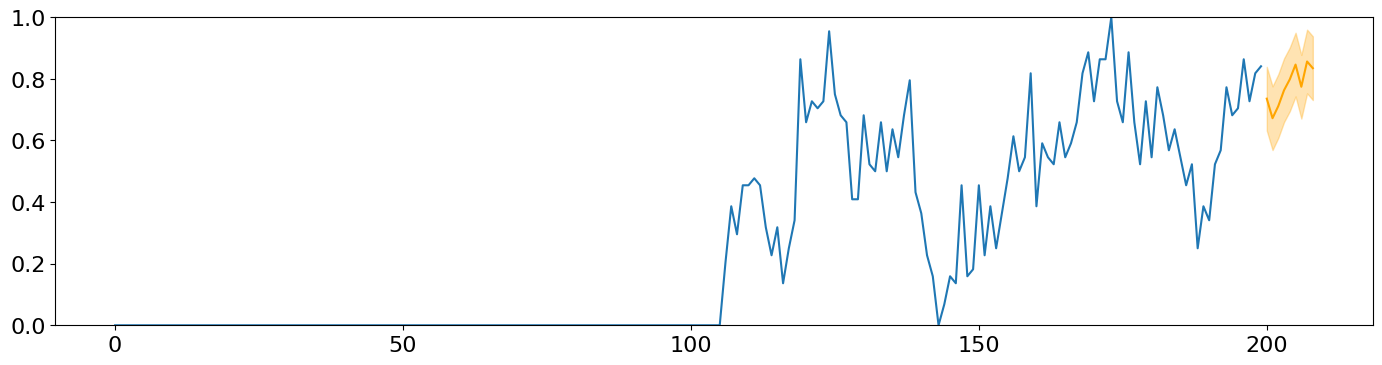

In [143]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## Time 2 Vec 2

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer


class Time2Vec(Layer):
    def __init__(self, kernel_size, periodic_activation='sin'):
        '''

        :param kernel_size:         The length of time vector representation.
        :param periodic_activation: The periodic activation, sine or cosine, or any future function.
        '''
        super(Time2Vec, self).__init__(
            trainable=True,
            name='Time2VecLayer_'+periodic_activation.upper()
        )

        self.k = kernel_size
        self.p_activation = periodic_activation

    def build(self, input_shape):
        # While i = 0
        self.wb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )

        self.bb = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            trainable=True
        )

        # Else needs to pass the periodic activation
        self.wa = self.add_weight(
            shape=(1, self.k),
            initializer='uniform',
            trainable=True
        )

        self.ba = self.add_weight(
            shape=(1, self.k),
            initializer='uniform',
            trainable=True
        )

        super(Time2Vec, self).build(input_shape)

    def call(self, inputs, **kwargs):
        '''

        :param inputs: A Tensor with shape (batch_size, feature_size, 1)
        :param kwargs:
        :return: A Tensor with shape (batch_size, feature_size, length of time vector representation + 1)
        '''
        bias = self.wb * inputs + self.bb
        if self.p_activation.startswith('sin') :
            wgts = K.sin(K.dot(inputs, self.wa) + self.ba)
        elif self.p_activation.startswith('cos') :
            wgts = K.cos(K.dot(inputs, self.wa) + self.ba)
        else:
            raise NotImplementedError('Neither sine or cosine periodic activation be selected.')
        return K.concatenate([bias, wgts], -1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.k + 1)

In [ ]:
# import os
#
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow.keras import layers, Model, backend as K
#from Time2Vec.layers import Time2Vec


def time2vec_lstm(dim, t2v_dim):
    '''

    :param dim:
    :param t2v_dim:
    :return:
    '''
    term = layers.Input(shape=(dim, 1))
    time = layers.Input(shape=(dim, 1))
    xti = Time2Vec(t2v_dim)(time)
    xte = layers.LSTM(32)(term)
    x = layers.Dense(9)(layers.concatenate([xte, layers.Flatten()(xti)]))
    m = Model([time, term], x)
    return m


def general_lstm(dim):
    inp = layers.Input(shape=(dim, 1))
    x = layers.LSTM(32)(inp)
    x = layers.Dense(9)(x)
    m = Model(inp, x)
    return m

In [ ]:
model = time2vec_lstm(200, 32)
model.compile(loss='mae', metrics=['mse'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 Time2VecLayer_SIN (Time2Ve  (None, 200, 33)              66        ['input_11[0][0]']            
 c)                                                                                               
                                                                                                  
 lstm_4 (LSTM)               (None, 32)                   4352      ['input_10[0][0]']      

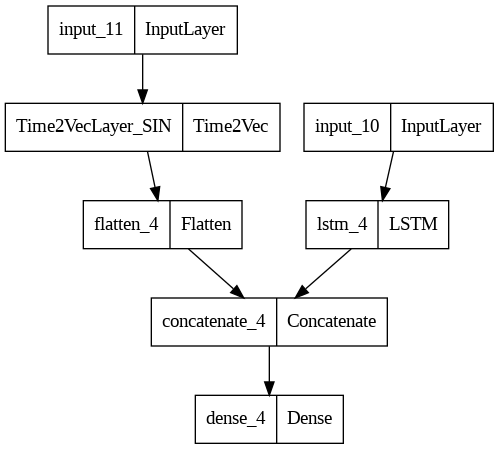

In [ ]:
tfk.utils.plot_model(model)

In [ ]:
history = model.fit(
    x=[X_train, X_train],
    y=y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=2,
    validation_split=0.2,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/10
1335/1335 - 15s - loss: 0.0711 - mse: 0.0125 - val_loss: 0.0741 - val_mse: 0.0144 - lr: 0.0010 - 15s/epoch - 11ms/step
Epoch 2/10
1335/1335 - 12s - loss: 0.0623 - mse: 0.0098 - val_loss: 0.0732 - val_mse: 0.0146 - lr: 0.0010 - 12s/epoch - 9ms/step
Epoch 3/10
1335/1335 - 12s - loss: 0.0614 - mse: 0.0096 - val_loss: 0.0738 - val_mse: 0.0147 - lr: 0.0010 - 12s/epoch - 9ms/step
Epoch 4/10
1335/1335 - 12s - loss: 0.0607 - mse: 0.0094 - val_loss: 0.0722 - val_mse: 0.0145 - lr: 0.0010 - 12s/epoch - 9ms/step
Epoch 5/10
1335/1335 - 12s - loss: 0.0601 - mse: 0.0093 - val_loss: 0.0720 - val_mse: 0.0144 - lr: 0.0010 - 12s/epoch - 9ms/step
Epoch 6/10


In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('time2vec_1')
model = tfk.models.load_model('time2vec_1')

Test evaluation

In [ ]:
y_test.shape

In [ ]:
# Predict the test set using the model
predictions = model.predict([X_test, X_test], verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

In [ ]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [ ]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [ ]:
future_predictions = model.predict(future,verbose=1)

In [ ]:
maes.shape

In [ ]:
future_predictions.shape

In [ ]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

## Ensemble

In [15]:
!ls

1D_CNN_Autoencoder			       LSTM_classifier
1DCNN_classifier			       LSTM_CNN
1DCNN_deeper_classifier			       LSTM_CNN_Attention
AirQuality.csv				       model.png
big_model_classifier			       residual_model_classifier
BiLSTM_classifier			       residual_model_masking_classifier
categories.npy				       test_model.h5
CONV_LSTM_long_data			       training_data.npy
CONV_LSTM_long_data-20231219T204717Z-001.zip   training_dataset.zip
CONV_LSTM_short_data			       transformer_deeper_forecasting
CONV_LSTM_short_data-20231219T204718Z-001.zip  transformer_deeper_forecasting_tensorflow
LSTM					       transformer_forecasting
LSTM_1					       transformer_forecasting_tensorflow
LSTM_2_Attention			       transformer_forecasting_try
LSTM_2_Attention_stride_50		       valid_periods.npy
LSTM_3_CNN				       VGG_classifier


In [13]:
!unzip CONV_LSTM_long_data-20231219T204717Z-001.zip

Archive:  CONV_LSTM_long_data-20231219T204717Z-001.zip
   creating: CONV_LSTM_long_data/assets/
  inflating: CONV_LSTM_long_data/keras_metadata.pb  
  inflating: CONV_LSTM_long_data/variables/variables.index  
  inflating: CONV_LSTM_long_data/fingerprint.pb  
  inflating: CONV_LSTM_long_data/saved_model.pb  
  inflating: CONV_LSTM_long_data/variables/variables.data-00000-of-00001  


In [14]:
!unzip CONV_LSTM_short_data-20231219T204718Z-001.zip

Archive:  CONV_LSTM_short_data-20231219T204718Z-001.zip
   creating: CONV_LSTM_short_data/assets/
  inflating: CONV_LSTM_short_data/fingerprint.pb  
  inflating: CONV_LSTM_short_data/keras_metadata.pb  
  inflating: CONV_LSTM_short_data/variables/variables.index  
  inflating: CONV_LSTM_short_data/variables/variables.data-00000-of-00001  
  inflating: CONV_LSTM_short_data/saved_model.pb  


In [34]:
conv_long = tf.keras.models.load_model('CONV_LSTM_long_data')
conv_short = tf.keras.models.load_model('CONV_LSTM_short_data')

In [58]:
# Predict the test set using the model
predictions_long = conv_long.predict(X_test, verbose=1)
predictions_short = conv_short.predict(X_test, verbose=1)

# Print the shape of the predictions
print(f"Predictions shape: {predictions_long.shape}")
print(f"Predictions shape: {predictions_short.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error_long = tfk.metrics.mean_squared_error(y_test.flatten(), predictions_long.flatten()).numpy()
print(f"Mean Squared Error Long: {mean_squared_error_long}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error_long = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions_long.flatten()).numpy()
print(f"Mean Absolute Error Long: {mean_absolute_error_long}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error_short = tfk.metrics.mean_squared_error(y_test.flatten(), predictions_short.flatten()).numpy()
print(f"Mean Squared Error Short: {mean_squared_error_short}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error_short = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions_short.flatten()).numpy()
print(f"Mean Absolute Error Short: {mean_absolute_error_short}")

1505/1505 [==============================] - 35s 22ms/step
Predictions shape: (48159, 9)
Predictions shape: (48159, 9)
Mean Squared Error Long: 0.02140064723789692
Mean Absolute Error Long: 0.09468009322881699
Mean Squared Error Short: 0.044861648231744766
Mean Absolute Error Short: 0.1434754580259323


In [64]:
# Calculate and print Mean Absolute Error (MAE)
mean_absolute_p_error_long = tfk.metrics.mean_absolute_percentage_error(y_test.flatten(), predictions_long.flatten()).numpy()
print(f"Mean Absolute Error Short: {mean_absolute_p_error_long}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_p_error_short = tfk.metrics.mean_absolute_percentage_error(y_test.flatten(), predictions_short.flatten()).numpy()
print(f"Mean Absolute Error Short: {mean_absolute_p_error_short}")

Mean Absolute Error Short: 1548883.625
Mean Absolute Error Short: 2520538.75


In [73]:
w = [1/mean_squared_error_short, 1/mean_squared_error_long]

In [75]:
w

[22.290754785339903, 46.72755869874671]

In [76]:
w_norm = w/np.linalg.norm(w)

In [77]:
np.linalg.norm(w_norm)

1.0

In [78]:
print(w_norm**2)

[0.18537845 0.81462155]


In [59]:
if mean_squared_error_long <= mean_squared_error_short:
  out = predictions_long
else:
  out = predictions_short

In [61]:
print(out==predictions_long)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


# Forecasting with Classes

## Data Preprocessing for Forecasting with classes

In [134]:
dataset = np.array(list_of_signals)
dataset.shape

(48000,)

In [135]:
unique_labels, indexes, counts = np.unique(categories, return_index=True, return_counts=True)

In [136]:
class_labels_numerical = [i for i in range(len(unique_labels))]
class_labels_numerical

[0, 1, 2, 3, 4, 5]

In [137]:
# Mapping categories to numerical values
category_mapping = {category: index for index, category in enumerate(unique_labels)}

# Convert categorical data to numerical labels
cat = [category_mapping[category] for category in categories]

# One-hot encode the numerical labels
cat = tfk.utils.to_categorical(cat)

In [138]:
cat.shape

(48000, 6)

In [139]:
test_prop = 0.2

X_train_raw = list()
X_test_raw = list()

cat_train_raw = list()
cat_test_raw = list()

for i in range(len(dataset)):
  test_index = int((1 - test_prop) * len(dataset[i]))
  X_train_raw.append(dataset[i][:test_index])
  X_test_raw.append(dataset[i][test_index:])
  cat_train_raw.append(cat[i])
  cat_test_raw.append(cat[i])

X_train_raw = np.array(X_train_raw)
X_test_raw = np.array(X_test_raw)

cat_train_raw = np.array(cat_train_raw)
cat_test_raw = np.array(cat_test_raw)

In [140]:
X_train_raw.shape, X_test_raw.shape, cat_train_raw.shape, cat_test_raw.shape

((48000,), (48000,), (48000, 6), (48000, 6))

In [144]:
window = 200
stride = 50
telescope = 9

def build_sequences_forecasting(X, categories, window, telescope, stride):
  new_X = []
  new_dataset = []
  new_labels_dataset = []
  new_cat_dataset = []
  new_X_noise = []
  for seq in X:
    padding_check = len(seq)%window
    n_of_windows = len(seq)//window
    if padding_check != 0:
      padding_len = window*(n_of_windows+1) + telescope - len(seq)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, seq))
    new_X.append(temp_unit)


  for i in range(len(new_X)):
      seq = new_X[i]

      if seq.shape[0] == window+telescope:
        end = 1
      else:
        end = seq.shape[0]-window-telescope

      for idx in range(0, end, stride):
          elem = np.array(new_X[i][idx:idx+window])
          cat = categories[i]
          lab = np.array(new_X[i][idx+window:idx+window+telescope]) # prediction labels
          new_cat_dataset.append(cat)
          new_dataset.append(elem)
          new_labels_dataset.append(lab)
          if elem.shape != (window,):
            print("error at index:")
            print(idx)

  new_dataset = np.array(new_dataset)
  new_labels_dataset = np.array(new_labels_dataset)
  new_cat_dataset = np.array(new_cat_dataset)

  return new_dataset, new_labels_dataset, new_cat_dataset

In [145]:
X_train, y_train, cat_train = build_sequences_forecasting(X_train_raw, cat_train_raw, window, telescope, stride)
X_test, y_test, cat_test = build_sequences_forecasting(X_test_raw, cat_test_raw, window, telescope, stride)

In [146]:
X_train.shape, y_train.shape, cat_train.shape, X_test.shape, y_test.shape, cat_test.shape

((106796, 200), (106796, 9), (106796, 6), (48159, 200), (48159, 9), (48159, 6))

In [147]:
direct_telescope = telescope

In [148]:
def inspect_multivariate(X, y, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.scatter(np.arange(len(X[0,:]), len(X_train[0,:])+telescope), y[idx,:], color='orange')
    #axs.set_ylim(0,1)
    plt.show()

In [149]:
inspect_multivariate(X_train, y_train, direct_telescope)

In [154]:
input_shape = (X_train.shape[1],1)
cat_input_shape = (cat_train.shape[1], 1)
output_shape = (y_train.shape[1],1)
batch_size = 64
epochs = 200

In [155]:
input_shape

(200, 1)

In [156]:
cat_input_shape

(6, 1)

In [157]:
output_shape

(9, 1)

## Transformer with classes

In [188]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = tfkl.LayerNormalization(epsilon=epsilon)(inputs)
  x = tfkl.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = tfkl.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = tfkl.LayerNormalization(epsilon=epsilon)(res)
  x = tfkl.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = tfkl.Dropout(dropout)(x)
  x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs, n_classes = 200, 1, 9, 6
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  classes_inputs = tf.keras.Input(shape=(n_classes))
  x = inputs
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
  x = tfkl.Flatten()(x)
  x = tfkl.Concatenate(axis=-1)([x, classes_inputs])
  x = tfkl.Dense(256, activation='relu')(x)

  for dim in mlp_units:
    x = tfkl.Dense(dim, activation="relu")(x)
    x = tfkl.Dropout(mlp_dropout)(x)

  outputs = tfkl.Dense(n_outputs)(x)
  return tf.keras.Model([inputs, classes_inputs], outputs)

In [189]:
model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
model.compile(loss='mae', metrics=['mse'], optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 layer_normalization_136 (L  (None, 200, 1)               2         ['input_31[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_68 (M  (None, 200, 1)               3585      ['layer_normalization_136[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

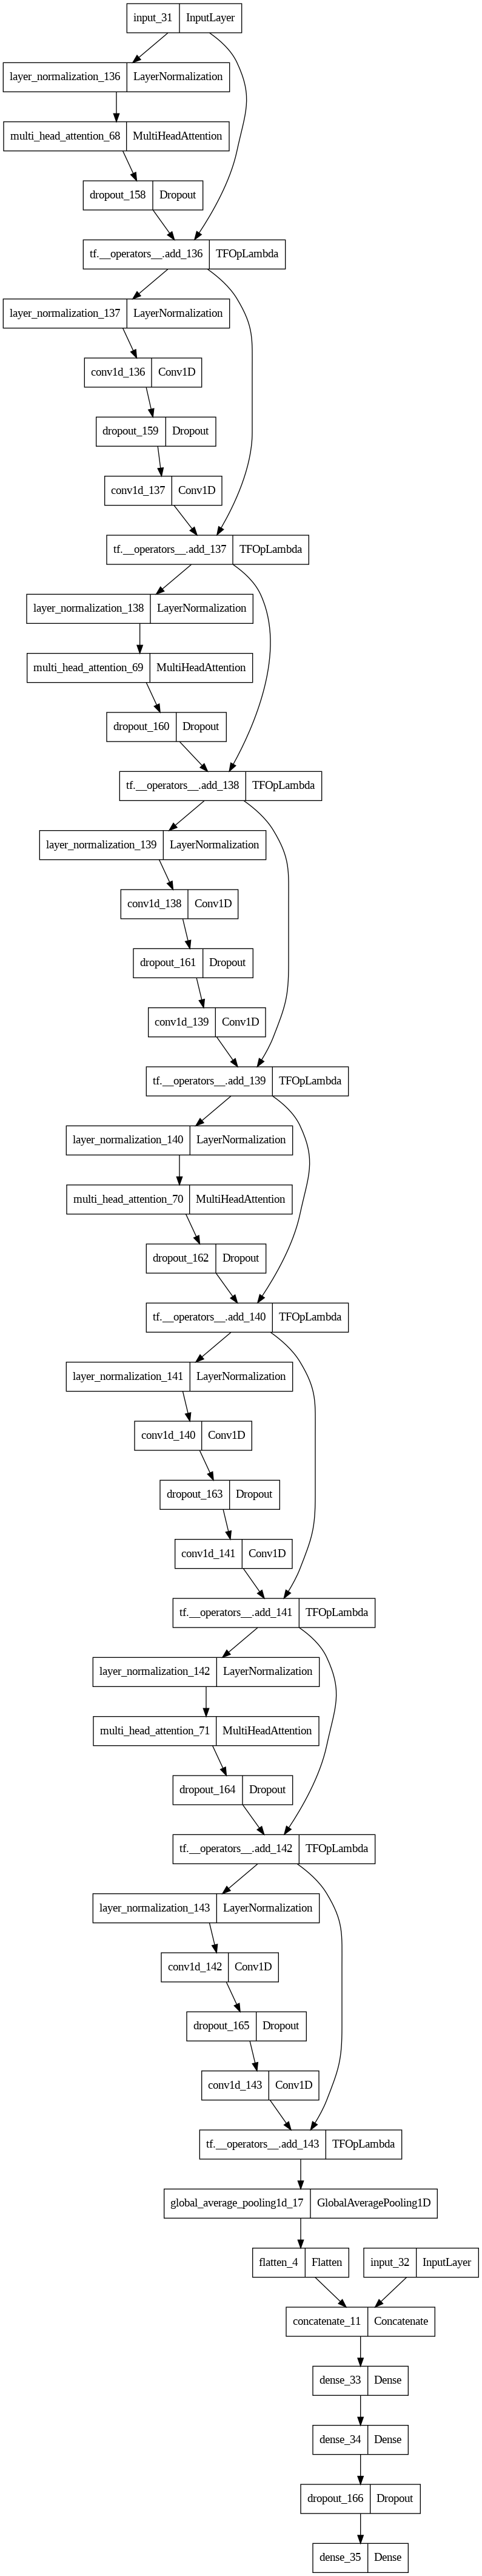

In [190]:
tfk.utils.plot_model(model)

In [191]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]

model.fit(
    [X_train, cat_train],
    y_train,
    validation_split=0.2,
    epochs= 150,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/150
1335/1335 [==============================] - 51s 30ms/step - loss: 0.0744 - mse: 0.0126 - val_loss: 0.0879 - val_mse: 0.0164
Epoch 2/150
1335/1335 [==============================] - 40s 30ms/step - loss: 0.0641 - mse: 0.0096 - val_loss: 0.0881 - val_mse: 0.0169
Epoch 3/150
1335/1335 [==============================] - 40s 30ms/step - loss: 0.0618 - mse: 0.0091 - val_loss: 0.0804 - val_mse: 0.0151
Epoch 4/150
1335/1335 [==============================] - 39s 30ms/step - loss: 0.0608 - mse: 0.0089 - val_loss: 0.0789 - val_mse: 0.0146
Epoch 5/150
1335/1335 [==============================] - 39s 29ms/step - loss: 0.0600 - mse: 0.0087 - val_loss: 0.0795 - val_mse: 0.0145
Epoch 6/150
1335/1335 [==============================] - 39s 30ms/step - loss: 0.0593 - mse: 0.0085 - val_loss: 0.0786 - val_mse: 0.0142
Epoch 7/150
1335/1335 [==============================] - 39s 30ms/step - loss: 0.0588 - mse: 0.0084 - val_loss: 0.0798 - val_mse: 0.0146
Epoch 8/150
1335/1335 [==================

In [203]:
model.save('transformer_forecasting_with_classes_2')

In [193]:
model = tf.keras.models.load_model('transformer_forecasting_with_classes')

In [204]:
model.save('transformer_forecasting_with_classes_2_tensorflow', save_format='tf', include_optimizer=True)

In [195]:
# Predict the test set using the model
predictions = model.predict([X_test, cat_test], verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (48159, 9)
Mean Squared Error: 0.022668883204460144
Mean Absolute Error: 0.10478786379098892


In [196]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([np.expand_dims(X[:,-1],axis=1),pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
    axs.plot(np.arange(len(X[0,:])), X[idx,:])
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), y[idx,:], color='orange')
    axs.plot(np.arange(len(X[0,:])-1, len(X[0,:])+telescope), pred[idx,:], color='green')
    axs.set_ylim(0,1)
    plt.show()

In [197]:
inspect_multivariate_prediction(X_test, y_test, predictions, direct_telescope)

Predict the future

In [198]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    ft_maes.append(np.mean(np.abs(y_test[:,i]-predictions[:,i]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [199]:
np.mean(np.abs(y_test[:,0]-predictions[:,0]))

0.06664641953294131

In [200]:
future = list()

for i in range(len(dataset)):
    elem = dataset[i][-window:]
    # pad to zero the shorter sequences
    if elem.shape != (200,):
      #print(elem.shape)
      padding_len = window - len(elem)
      padding = np.zeros(padding_len, dtype='float32')
      temp_unit = np.concatenate((padding, elem))
    else:
      temp_unit = elem

    future.append(temp_unit)

future = np.array(future)

In [201]:
for i in range(len(future)):
  if future[i].shape != (200,):
    print('error at index :')
    print(i)
    print(future[i].shape)

In [202]:
future_predictions = model.predict(future,verbose=1)

ValueError: ignored

In [ ]:
maes.shape

In [ ]:
future_predictions.shape

In [ ]:
figs, axs = plt.subplots(1, 1, sharex=True, figsize=(17,4))
idx = np.random.randint(future_predictions.shape[1])
axs.plot(np.arange(len(future[idx])), future[idx])
axs.plot(np.arange(len(future[idx]), len(future[idx])+direct_telescope), future_predictions[idx], color='orange')
axs.fill_between(
    np.arange(len(future[idx]), len(future[idx])+direct_telescope),
    future_predictions[idx]+maes[idx],
    future_predictions[idx]-maes[idx],
    color='orange', alpha=.3)
axs.set_ylim(0,1)
plt.show()

In [ ]:
model = tfk.models.load_model('transformer_forecasting_with_classes')

In [ ]:
# Predict the test set using the model
predictions = model.predict([X_test, cat_test], verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
print(X_test.shape)
new = np.concatenate([X_test, predictions], axis=1)
print(new.shape)
x_new = new[:,-200:]
print(x_new.shape)

In [ ]:
# Predict the test set using the model
predictions2 = model.predict([x_new, cat_test], verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions2.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions2.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions2.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
final_pred = np.concatenate([predictions, predictions2], axis=1)
final_pred.shape

In [ ]:
## final block of code to be put in model.py
predictions = model.predict(X_test, verbose=0)
X_test_new = np.concatenate([X_test, predictions], axis=1)[:,-200:]
predictions2 = model.predict(X_test_new, verbose=0)
final_pred = np.concatenate([predictions, predictions2], axis=1)